In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import sklearn.metrics as metric
import matplotlib.pyplot as plt 
from Plot import init_style, to_pgf
from collections import defaultdict
import matplotlib as mpl
from pathlib import Path
import os 


In [2]:
init_style()


In [3]:
COLOR = ["#EEEFEB", "#ECCD61", "#7FA3C2", "#B88FD5"]
PATCH = [None, "//o", None, "//."]


In [4]:
sns.color_palette(COLOR)


[(0.9333333333333333, 0.9372549019607843, 0.9215686274509803),
 (0.9254901960784314, 0.803921568627451, 0.3803921568627451),
 (0.4980392156862745, 0.6392156862745098, 0.7607843137254902),
 (0.7215686274509804, 0.5607843137254902, 0.8352941176470589)]

In [5]:
%matplotlib inline


In [6]:
class Metrics:
    ftrain, fval, ftest = Path("train_stats.tsv"), Path("val_stats.tsv"), Path("test_stats.tsv")

    def format_df(df):
        conv = {"PN_1_1": "Overlap",
                "TF_split": "TF-split",
                "TG_split": "TG-split",
                "TF_TG_split": "TFTG-split"}
        
        df["Dataset"] = df.Dataset.apply(lambda x: conv[x] if x in conv.keys() else x)
        return df 
    
    def __init__(self, dir):
        self.dir = Path(dir)
        self.train = Metrics.format_df(pd.read_table(self.dir.joinpath(Metrics.ftrain), index_col=0))
        self.val = Metrics.format_df(pd.read_table(self.dir.joinpath(Metrics.fval), index_col=0))
        self.test = Metrics.format_df(pd.read_table(self.dir.joinpath(Metrics.ftest), index_col=0))


In [7]:
def performance_report(df):
    data_array = []
    index1, index2 = [], []
    col_names = ["Precision", "Recall", "F1-score", "Accuracy"]

    for name, frame in df.groupby(["Dataset", "Model"]): 
        index1.append(name[0])
        index2.append(name[1])
        lab = frame.Label 
        prob = frame.Pred
        pred_lab = (prob >= 0.5).astype(int)
        report = pd.DataFrame.from_dict(metric.classification_report(lab, pred_lab, output_dict=True))
        metrics = report.iloc[:3, 1].to_list()
        metrics += [report["accuracy"].unique().item()]
        data_array.append(metrics)

    metric_report = pd.DataFrame(data_array, index=[index1, index2], columns=col_names)
    metric_report = metric_report.loc[["Overlap", "TF-split", "TG-split", "TFTG-split"]]
    return metric_report


In [8]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )


def shaded_line(mean, std, color, ax, label):
    ax.plot(range(len(mean)), mean, '-', label=label, color=color)
    ax.fill_between(range(len(mean)), mean - std, mean + std, color=color, alpha=0.2)


def loss_plot(train, val):
    n_col = train.Model.nunique()
    fig, axs = plt.subplots(4, n_col, figsize=(6.5, 9), sharex=True, sharey=True)
    row_names = ["Overlap", "TF-split", "TG-split", "TFTG-split"]
    col_names = []
    

    row_i = 0
    for i, (name, frame) in enumerate(train.groupby(["Dataset", "Model"])):
        if name[1] not in col_names:
            col_names.append(name[1])
        j = i % n_col
        if j == 0 and i > 0:
            row_i += 1 
        ax = axs[row_i, j]
        train_loss = frame.groupby("Epoch").Loss.mean().to_numpy()
        train_std = frame.groupby("Epoch").Loss.std().to_numpy()
        shaded_line(train_loss, train_std, "b", ax, "Train")

        val_frame = val.loc[(val["Dataset"] == name[0]) & (val["Model"] == name[1])]
        val_loss = val_frame.groupby("Epoch").Mean_loss.mean().to_numpy()
        val_std = val_frame.groupby("Epoch").Mean_loss.std().to_numpy()
        shaded_line(val_loss, val_std, "r", ax, "Val")
        # axs[row_i, j].set_title(name[0] + " " + name[1])

        print(row_i, j, name)
    print(col_names)
    add_headers(fig, row_headers=row_names, col_headers=col_names)
    # fig.tight_layout(pad=4)
    fig.supxlabel("Epoch", fontsize=14)
    fig.supylabel("Loss (mean)", fontsize=14)
    

def acc_plot(val):
    n_col = val.Model.nunique()
    fig, axs = plt.subplots(4, n_col, figsize=(3.54*3, 3.54*3), sharex=True, sharey=True)
    row_names = []
    col_names = []
    print(row_names)

    row_i = 0
    for i, (name, frame) in enumerate(val.groupby(["Dataset", "Model"])):
        if name[0] not in row_names:
            row_names.append(name[0])
        if name[1] not in col_names:
            col_names.append(name[1])
        j = i % n_col
        if j == 0 and i > 0:
            row_i += 1 
        ax = axs[row_i, j]
        val_mean = frame.groupby("Epoch").Accuracy.mean().to_numpy()
        val_std = frame.groupby("Epoch").Accuracy.std().to_numpy()
        shaded_line(val_mean, val_std, "g", ax, "Val")

        print(row_i, j, name)
    add_headers(fig, row_headers=row_names, col_headers=col_names)
    fig.tight_layout(pad=4)
    fig.supxlabel("Epoch", fontsize=14)
    fig.supylabel("Accuracy (mean)", fontsize=14)


In [9]:
os.chdir("/home/llan/Desktop/WUR/thesis2/")


# g2v_embeddings size & encoder

In [558]:
wo_enc = Metrics("media2/base_line/random_embedding")
d100 = Metrics("media2/base_line/g2v_100")
d1000 = Metrics("media2/base_line/g2v_1000")


In [559]:
wo_enc.test


Dataset Model  Run     TF  Target  Label      Pred
0       Overlap   G2V    0      5   12597      1  0.362849
1       Overlap   G2V    0      5    4626      1  0.861954
2       Overlap   G2V    0      5   36347      1  0.813879
3       Overlap   G2V    0     57   26018      1  0.632519
4       Overlap   G2V    0    146    4276      1  0.686293
...         ...   ...  ...    ...     ...    ...       ...
69475  TG-split   EXP    9  36415   14399      0  0.401154
69476  TG-split   EXP    9  36454   29409      0  0.540235
69477  TG-split   EXP    9  36454    6225      0  0.337009
69478  TG-split   EXP    9  36454   14467      0  0.380620
69479  TG-split   EXP    9  36459   32564      0  0.422176

[69480 rows x 7 columns]

In [560]:
def escape_underscores(df):
    """Escapes all underscore characters in a Pandas DataFrame."""
    return df.map(lambda x: x.replace("_", r"\_") if isinstance(x, str) else x)


def auc_scores(test_df):
    roc_scores = defaultdict(list)
    prc_scores = defaultdict(list)

    for name, frame in test_df.groupby(["Dataset", "Model", "Run"]):
        name = name[:2]
        #frame["pred_label"] = (frame.Pred >= 0.5).astype(int)
        roc_scores[name].append(metric.roc_auc_score(frame.Label, frame.Pred))

        precision, recall, _ = metric.precision_recall_curve(frame.Label, frame.Pred)

        prc_scores[name].append(metric.auc(recall, precision))
    return roc_scores, prc_scores

# def grouped_bar(df, pal="muted", height=3.25, aspect=1.0):
#     # ax = plt.figure()
#     g = sns.catplot(
#         data=df, kind="bar",
#         x="variable_0", y="value", hue="variable_1",
#         errorbar="se", palette=pal, alpha=.6,
#         facet_kws={"despine": False}, order=["Overlap", "TF-split", "TG-split", "TFTG-split"],
#         capsize=.2,
#         height=height,
#         aspect=aspect
#     )
#     plt.axhline(y = 0.5, color = 'r', linestyle = '-.', alpha=0.8) 
#     plt.ylim(0, 1.05)

#     g.set_xlabels("Dataset")
#     g.set_ylabels("AUROC (mean)")
#     # g._legend.set_title("Model")
#     sns.move_legend(
#     g, "lower center",
#     bbox_to_anchor=(.45, 0.98), ncol=3, title=None)


In [561]:
#["ROC (mean)", "ROC (SEM)", "PRC (mean)", "PRC (SEM)"]

In [12]:
def auc_scores(test_df, groups):
    roc_scores = defaultdict(list)
    prc_scores = defaultdict(list)

    for name, frame in test_df.groupby(groups + ["Run"]):
        name = name[:-1]
        #frame["pred_label"] = (frame.Pred >= 0.5).astype(int)
        roc_scores[name].append(metric.roc_auc_score(frame.Label, frame.Pred))

        precision, recall, _ = metric.precision_recall_curve(frame.Label, frame.Pred)

        prc_scores[name].append(metric.auc(recall, precision))
    return roc_scores, prc_scores

def df_from_auc(roc, prc):
    roc = pd.DataFrame.from_dict(roc).melt()
    prc = pd.DataFrame.from_dict(prc).melt()
    roc = roc.groupby(["variable_0", "variable_1"]).agg(["mean", "sem"])
    prc = prc.groupby(["variable_0", "variable_1"]).agg(["mean", "sem"])
    df = pd.concat((roc, prc), axis=1)
    df.columns = pd.MultiIndex.from_tuples(list(zip(["ROC", "ROC", "PRC", "PRC"], ["(mean)", "(SEM)"] * 2)))
    df.index.names = ["Dataset", "Model"]
    df = df.round(3)
    return df



In [13]:
COLOR = ["#EEEFEB", "#ECCD61", "#7FA3C2", "#B88FD5"]
PATCH = [None, "oooo", None, "xxxx"]


def grouped_bar(scores):
    dataset = np.unique([x[0] for x in scores.keys()]).tolist()
    model = np.unique([x[1] for x in scores.keys()]).tolist()
    x = np.array([0 + i * 0.30 for i in range(len(model))])
    pad = np.array([0.25] * len(dataset))
    ncols = 2

    if len(model) > 3:
        pad = np.array(list(range(len(dataset))))
        pad = pad * 0.35
        ncols = len(model)/2

    print(pad)
    scores = list(scores.items())
    w = 0.25
    mlt = 0 

    fig, ax = plt.subplots()
    
    for i in range(len(dataset)):
        ii = i * len(model)
        data = scores[ii:ii+len(model)]
        stderr = [np.std(val[1], ddof=1) / np.sqrt(len(val[1])) for 
                  val in data]
        mean = [np.mean(val[1]) for val in data]
      
        p = ax.bar(x + i+ pad[i], mean, w, label=model, edgecolor="black", 
                   hatch=PATCH[:len(model)], color=COLOR[:len(model)], linewidth=0.5)
        ax.bar_label(p, labels=[f'{round(val, 1)}' for val in mean], padding=3)
        
        

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles)) 
    
    ax.legend(unique.values(), unique.keys(),
                loc="upper center", ncols=ncols,
                bbox_to_anchor=(0.5, 1.15), frameon=False)
    ax.set_ylim((0, 1 + 1/5))
    xticks = [np.mean(x + i + pad[i]) for i in range(len(dataset))]
    ax.set_xticks(xticks, dataset)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dataset")
    ax.set_ylabel("AUROC (mean)")

In [14]:
def init_style():
    plt.style.use("default")

    mpl.rcParams.update({
        "savefig.bbox": "tight",
        "pgf.texsystem": "lualatex",  # Use lualatex for LaTeX processing
        "text.usetex": True,          # Use LaTeX for text rendering
        "font.family": "serif",
        "font.size": 6,               # Base font size (adjusted smaller)
        "axes.titlesize": 8,          # Title font size (smaller)
        "axes.labelsize": 7,          # Axis labels font size (smaller)
        "xtick.labelsize": 6,         # X-axis tick label font size (smaller)
        "ytick.labelsize": 6,         # Y-axis tick label font size (smaller)
        "legend.fontsize": 6,         # Legend font size (smaller)
        "lines.linewidth": 0.9,       # Line width for plot lines (adjusted thinner)
        "lines.markersize": 3,        # Marker size (adjusted smaller)
        "hatch.linewidth": 0.4,
        # Figure size in inches (adjusted for better fitting in thesis template)
        "figure.figsize": (2.96, 2.96 * 0.8),
        "figure.dpi": 400,            # DPI for rasterized output
        "savefig.dpi": 400,           # DPI for saved figures
        "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}
        \usepackage[T1]{fontenc}
        \usepackage{lmodern}
        \usepackage{siunitx}
        \usepackage{amsmath}
        """,
        "axes.grid": False,           # Disable grid for cleaner presentation
        "grid.alpha": 0.3,            # Grid transparency
        "grid.linestyle": ":",        # Grid line style
        "axes.linewidth": 0.5
    })

init_style()

In [15]:
np.arange(0,4)

array([0, 1, 2, 3])

[0.   0.35 0.7 ]


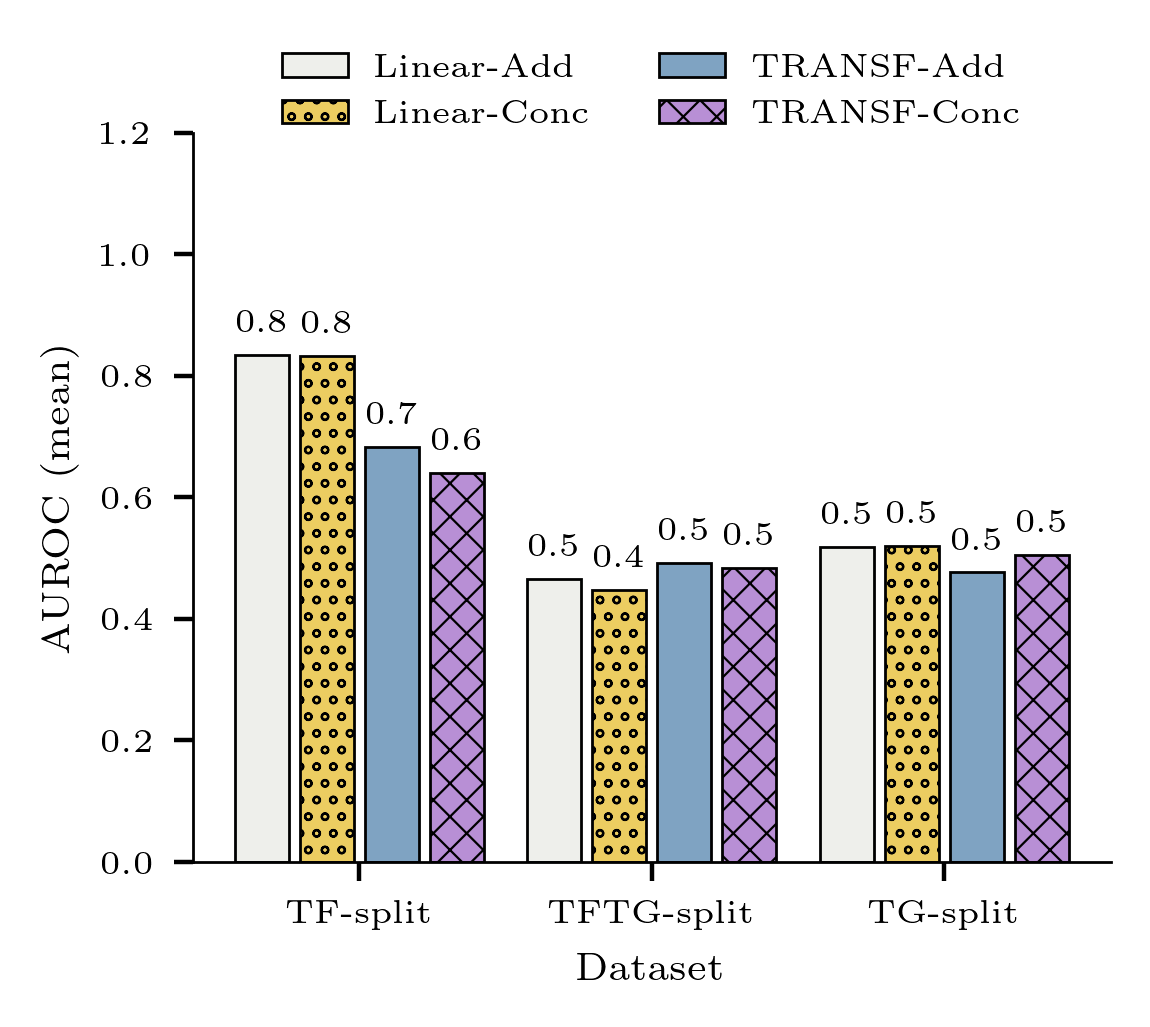

In [775]:
grouped_bar(roc)
plt.savefig('TESTS.pdf', format='pdf', bbox_inches='tight')


In [776]:
comp = dict()
input_data = {
    "w/o encoder": wo_enc,
    "D100": d100,
    "D1000": d1000
    }

for key, val in input_data.items():
    roc, prc = auc_scores(val.test)
    for comb, val in roc.items():
        if "G2V" in comb:
            comp[(comb[0], key)] = val

g2v_comp_df = pd.DataFrame.from_dict(comp).melt()
grouped_bar(g2v_comp_df, "rocket")
plt.savefig("media2/encoder_effect.pgf")
# to_pgf("media2/encoder_effect.pgf")


TypeError: auc_scores() missing 1 required positional argument: 'groups'

In [14]:
g2v_perf = pd.concat((performance_report(wo_enc.test).xs("G2V", level=1),
performance_report(d100.test).xs("G2V", level=1),
performance_report(d1000.test).xs("G2V", level=1)))

g2v_perf.reset_index(inplace=True)
g2v_perf["Model"] = 4*["wo_encoder"] + 4*["D100"] + 4*["D1000"] 
g2v_perf.sort_values(by="index", inplace=True)
g2v_perf = g2v_perf.set_index(["index", "Model"])
g2v_perf.loc[["Overlap", "TF-split", "TG-split", "TFTG-split"]]



Precision    Recall  F1-score  Accuracy
index      Model                                              
Overlap    wo_encoder   0.870407  0.915405  0.892339  0.897330
           D100         0.979344  0.990339  0.984811  0.985801
           D1000        0.987587  0.997128  0.992335  0.992840
TF-split   wo_encoder   0.501079  0.524194  0.512376  0.501129
           D100         0.546780  0.665484  0.600320  0.556935
           D1000        0.611619  0.733548  0.667058  0.633871
TG-split   wo_encoder   0.505199  0.597792  0.547609  0.506151
           D100         0.483085  0.531546  0.506158  0.481388
           D1000        0.500426  0.556151  0.526819  0.500473
TFTG-split wo_encoder   0.491109  0.487395  0.489245  0.491176
           D100         0.504983  0.383193  0.435738  0.503782
           D1000        0.497948  0.305882  0.378969  0.498739

# Importance of Data split

In [27]:
rdb = Metrics("media2/base_line/g2v_1000")

In [28]:
roc, prc = auc_scores(rdb.test, ["Dataset", "Model"])


[0.25 0.25 0.25 0.25]


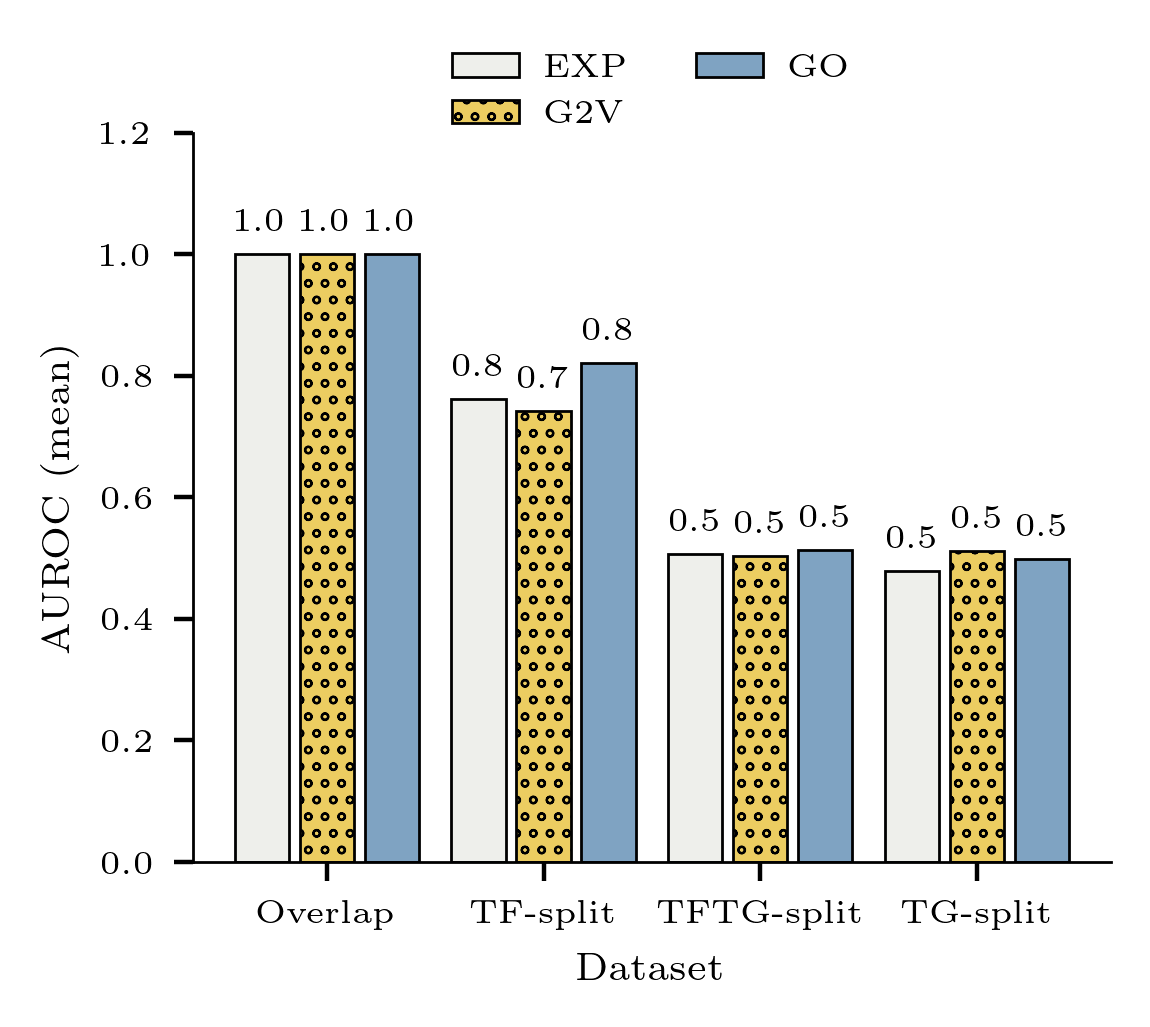

In [29]:
grouped_bar(roc)
#plt.savefig("media2/base_line/auc_roc.pdf")

In [30]:
roc, prc = auc_scores(rdb.test, ["Dataset", "Model"])
print(df_from_auc(roc, prc).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXP & 0.999 & 0.000 & 0.999 & 0.000 \\
 & G2V & 1.000 & 0.000 & 1.000 & 0.000 \\
 & GO & 1.000 & 0.000 & 1.000 & 0.000 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXP & 0.762 & 0.005 & 0.780 & 0.006 \\
 & G2V & 0.742 & 0.009 & 0.768 & 0.009 \\
 & GO & 0.820 & 0.002 & 0.871 & 0.002 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXP & 0.506 & 0.012 & 0.516 & 0.011 \\
 & G2V & 0.504 & 0.008 & 0.514 & 0.011 \\
 & GO & 0.513 & 0.010 & 0.521 & 0.010 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXP & 0.478 & 0.007 & 0.500 & 0.007 \\
 & G2V & 0.512 & 0.008 & 0.517 & 0.007 \\
 & GO & 0.499 & 0.006 & 0.495 & 0.007 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [31]:
baseline_auc = df_from_auc(roc, prc)

In [32]:
baseline_met = performance_report(rdb.test)

In [579]:
print(performance_report(rdb.test).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & Precision & Recall & F1-score & Accuracy \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXP & 0.986 & 0.996 & 0.991 & 0.992 \\
 & G2V & 0.988 & 0.997 & 0.992 & 0.993 \\
 & GO & 0.987 & 1.000 & 0.993 & 0.994 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXP & 0.676 & 0.681 & 0.679 & 0.678 \\
 & G2V & 0.612 & 0.734 & 0.667 & 0.634 \\
 & GO & 0.709 & 0.754 & 0.731 & 0.722 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXP & 0.488 & 0.368 & 0.420 & 0.491 \\
 & G2V & 0.500 & 0.556 & 0.527 & 0.500 \\
 & GO & 0.511 & 0.384 & 0.439 & 0.508 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXP & 0.506 & 0.632 & 0.562 & 0.508 \\
 & G2V & 0.498 & 0.306 & 0.379 & 0.499 \\
 & GO & 0.506 & 0.518 & 0.512 & 0.506 \\
\cline{1-6}
\bottomrule
\end{tabular}



# network analysis

In [816]:
idx_files = { 
    "Overlap": "/home/llan/Desktop/WUR/thesis2/shared_data/binary_labels/BaseLine/PN_1_1",
    "TF-split": "/home/llan/Desktop/WUR/thesis2/shared_data/binary_labels/BaseLine/TF_split",
    "TFTG-split": "/home/llan/Desktop/WUR/thesis2/shared_data/binary_labels/BaseLine/TF_TG_split",
    "TG-split": "/home/llan/Desktop/WUR/thesis2/shared_data/binary_labels/BaseLine/TG_split"
}


In [817]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def network(file, train=True):
    G = nx.Graph()  # Use DiGraph for directed arrows
    if train:
        dftrain = pd.read_table(Path(file).joinpath("Train_set.tsv"), index_col=0)
        for lab in [0, 1]:
            net = dftrain.loc[dftrain["Label"] == lab]
            edge_style = "dashed" if lab == 0 else "solid"  # Dashed for lab=0
            G.add_nodes_from([(node, {"color": "#ffa600"}) for node in net.TF.tolist()])
            G.add_nodes_from([(node, {"color": "#2f4b7c"}) for node in net.Target.tolist()])
            G.add_edges_from([(tf, tg, {"color": "grey", "style": edge_style}) for tf, tg in net[["TF", "Target"]].values])
    if not train:
        dftest = pd.read_table(Path(file).joinpath("Test_set.tsv"), index_col=0)
        for lab in [0, 1]:
            net = dftest.loc[dftest["Label"] == lab]
            edge_style = "dashed" if lab == 0 else "solid"
            G.add_nodes_from([(node, {"color": "#ffa600"}) for node in net.TF.tolist()])
            G.add_nodes_from([(node, {"color": "#2f4b7c"}) for node in net.Target.tolist()])
            G.add_edges_from([(tf, tg, {"color": "grey", "style": edge_style}) for tf, tg in net[["TF", "Target"]].values])

    return G

def plot_graph(G, ax):
    pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")

    node_colors = [G.nodes[node]["color"] for node in G.nodes]
    edge_colors = [G.edges[edge]["color"] for edge in G.edges]
    edge_styles = [G.edges[edge]["style"] for edge in G.edges]

    for edge, style, color in zip(G.edges, edge_styles, edge_colors):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color, style=style, alpha=0.4, width=0.8, ax=ax)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=15, edgecolors="black", alpha=1, linewidths=0.3, ax=ax)
    

# Example usage:
# G = network("path/to/data")
# plot_graph(G)


Overlap
3.887814313346228
TF-split
2.1611170784103115
TFTG-split
4.589861751152074
TG-split
2.127253446447508


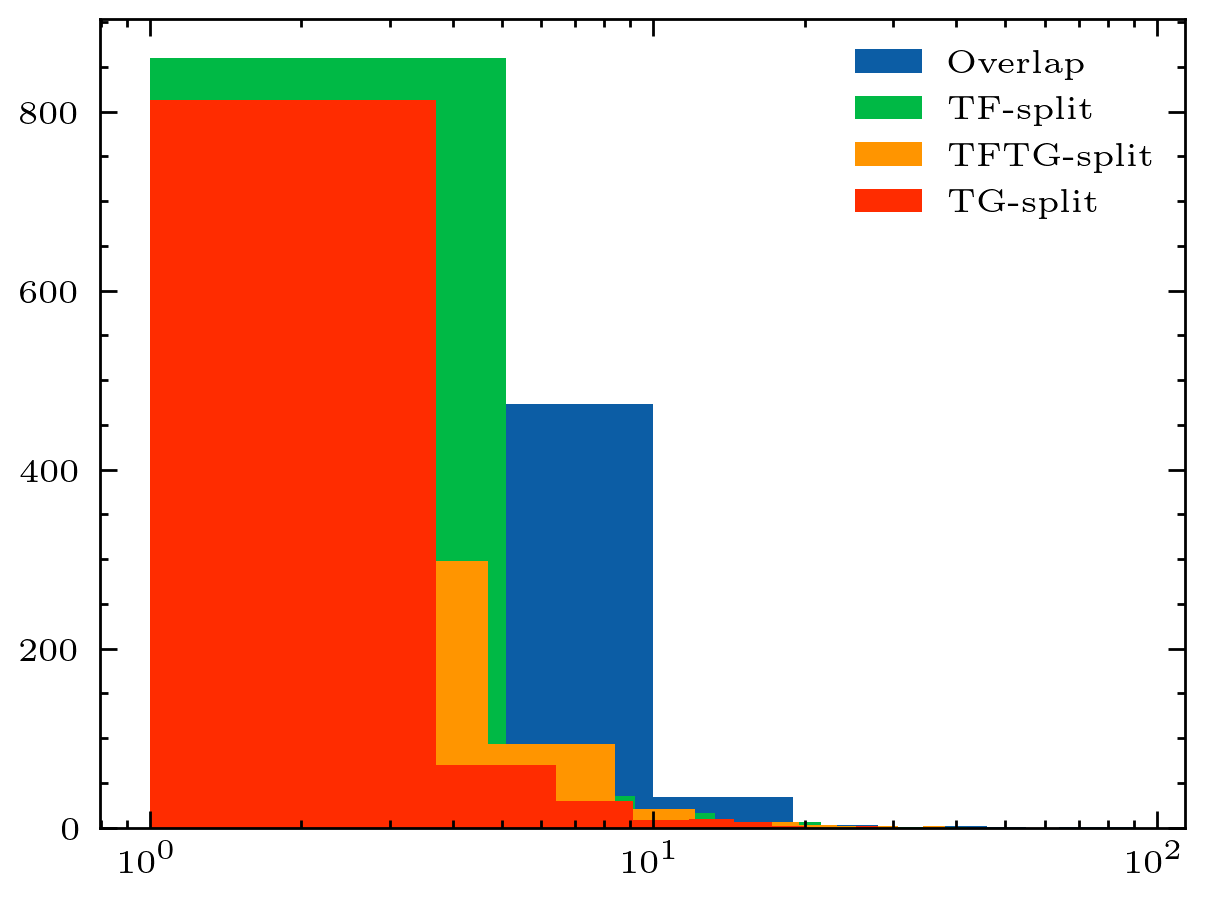

In [818]:
for name, file in idx_files.items():
    print(name)
    graph = network(file)
    avg_degree = sum(dict(graph.degree()).values())/len(graph.degree)
    print(avg_degree)
    plt.hist([val for (key, val) in graph.degree], label=name, alpha=1.0)
    plt.legend()
    plt.xscale("log")


In [819]:
dict(graph.degree()).values()


dict_values([3, 9, 12, 5, 5, 3, 14, 19, 2, 11, 9, 3, 7, 28, 15, 5, 2, 11, 17, 4, 3, 12, 3, 7, 6, 5, 2, 9, 26, 9, 6, 13, 12, 3, 3, 1, 3, 13, 13, 7, 8, 4, 16, 3, 1, 5, 7, 11, 1, 5, 7, 10, 1, 15, 7, 6, 5, 5, 4, 2, 3, 7, 3, 16, 16, 8, 9, 5, 10, 2, 2, 5, 16, 8, 6, 2, 2, 3, 3, 6, 2, 4, 3, 3, 5, 4, 5, 5, 5, 8, 2, 4, 13, 4, 4, 3, 6, 8, 5, 6, 3, 4, 2, 2, 10, 3, 7, 12, 9, 6, 19, 3, 2, 4, 2, 6, 1, 3, 7, 8, 4, 2, 2, 14, 2, 7, 7, 8, 2, 1, 6, 1, 9, 4, 6, 6, 2, 1, 11, 6, 2, 11, 6, 5, 4, 4, 2, 3, 7, 2, 5, 2, 3, 6, 2, 1, 2, 2, 2, 4, 5, 3, 1, 3, 1, 5, 2, 1, 7, 3, 1, 4, 2, 2, 2, 2, 3, 3, 2, 2, 4, 3, 3, 7, 1, 2, 2, 5, 3, 5, 2, 7, 4, 4, 2, 2, 2, 4, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1

In [ ]:
import matplotlib.patches as mpatches
f_patch = mpatches.Patch(color='#ffa600', label='TF Nodes')
target_patch = mpatches.Patch(color='#2f4b7c', label='Target Nodes')


In [823]:
import sys
sys.path.append("Code")
from Utils import ConfigSampler3D

In [1016]:
c  = ConfigSampler3D()

In [1017]:
i = 0
while True:
    i += 1
    if i < 3888:
        c.sample_config()
        print(f"\rsuccessful sample event i={i}", end="", flush=True)
    else:
        print(f"\rreached all combinations i={i}, trying to get new unique config", end="", flush=True)
        c.sample_config()

        

reached all combinations i=3889, trying to get new unique config

KeyboardInterrupt: 

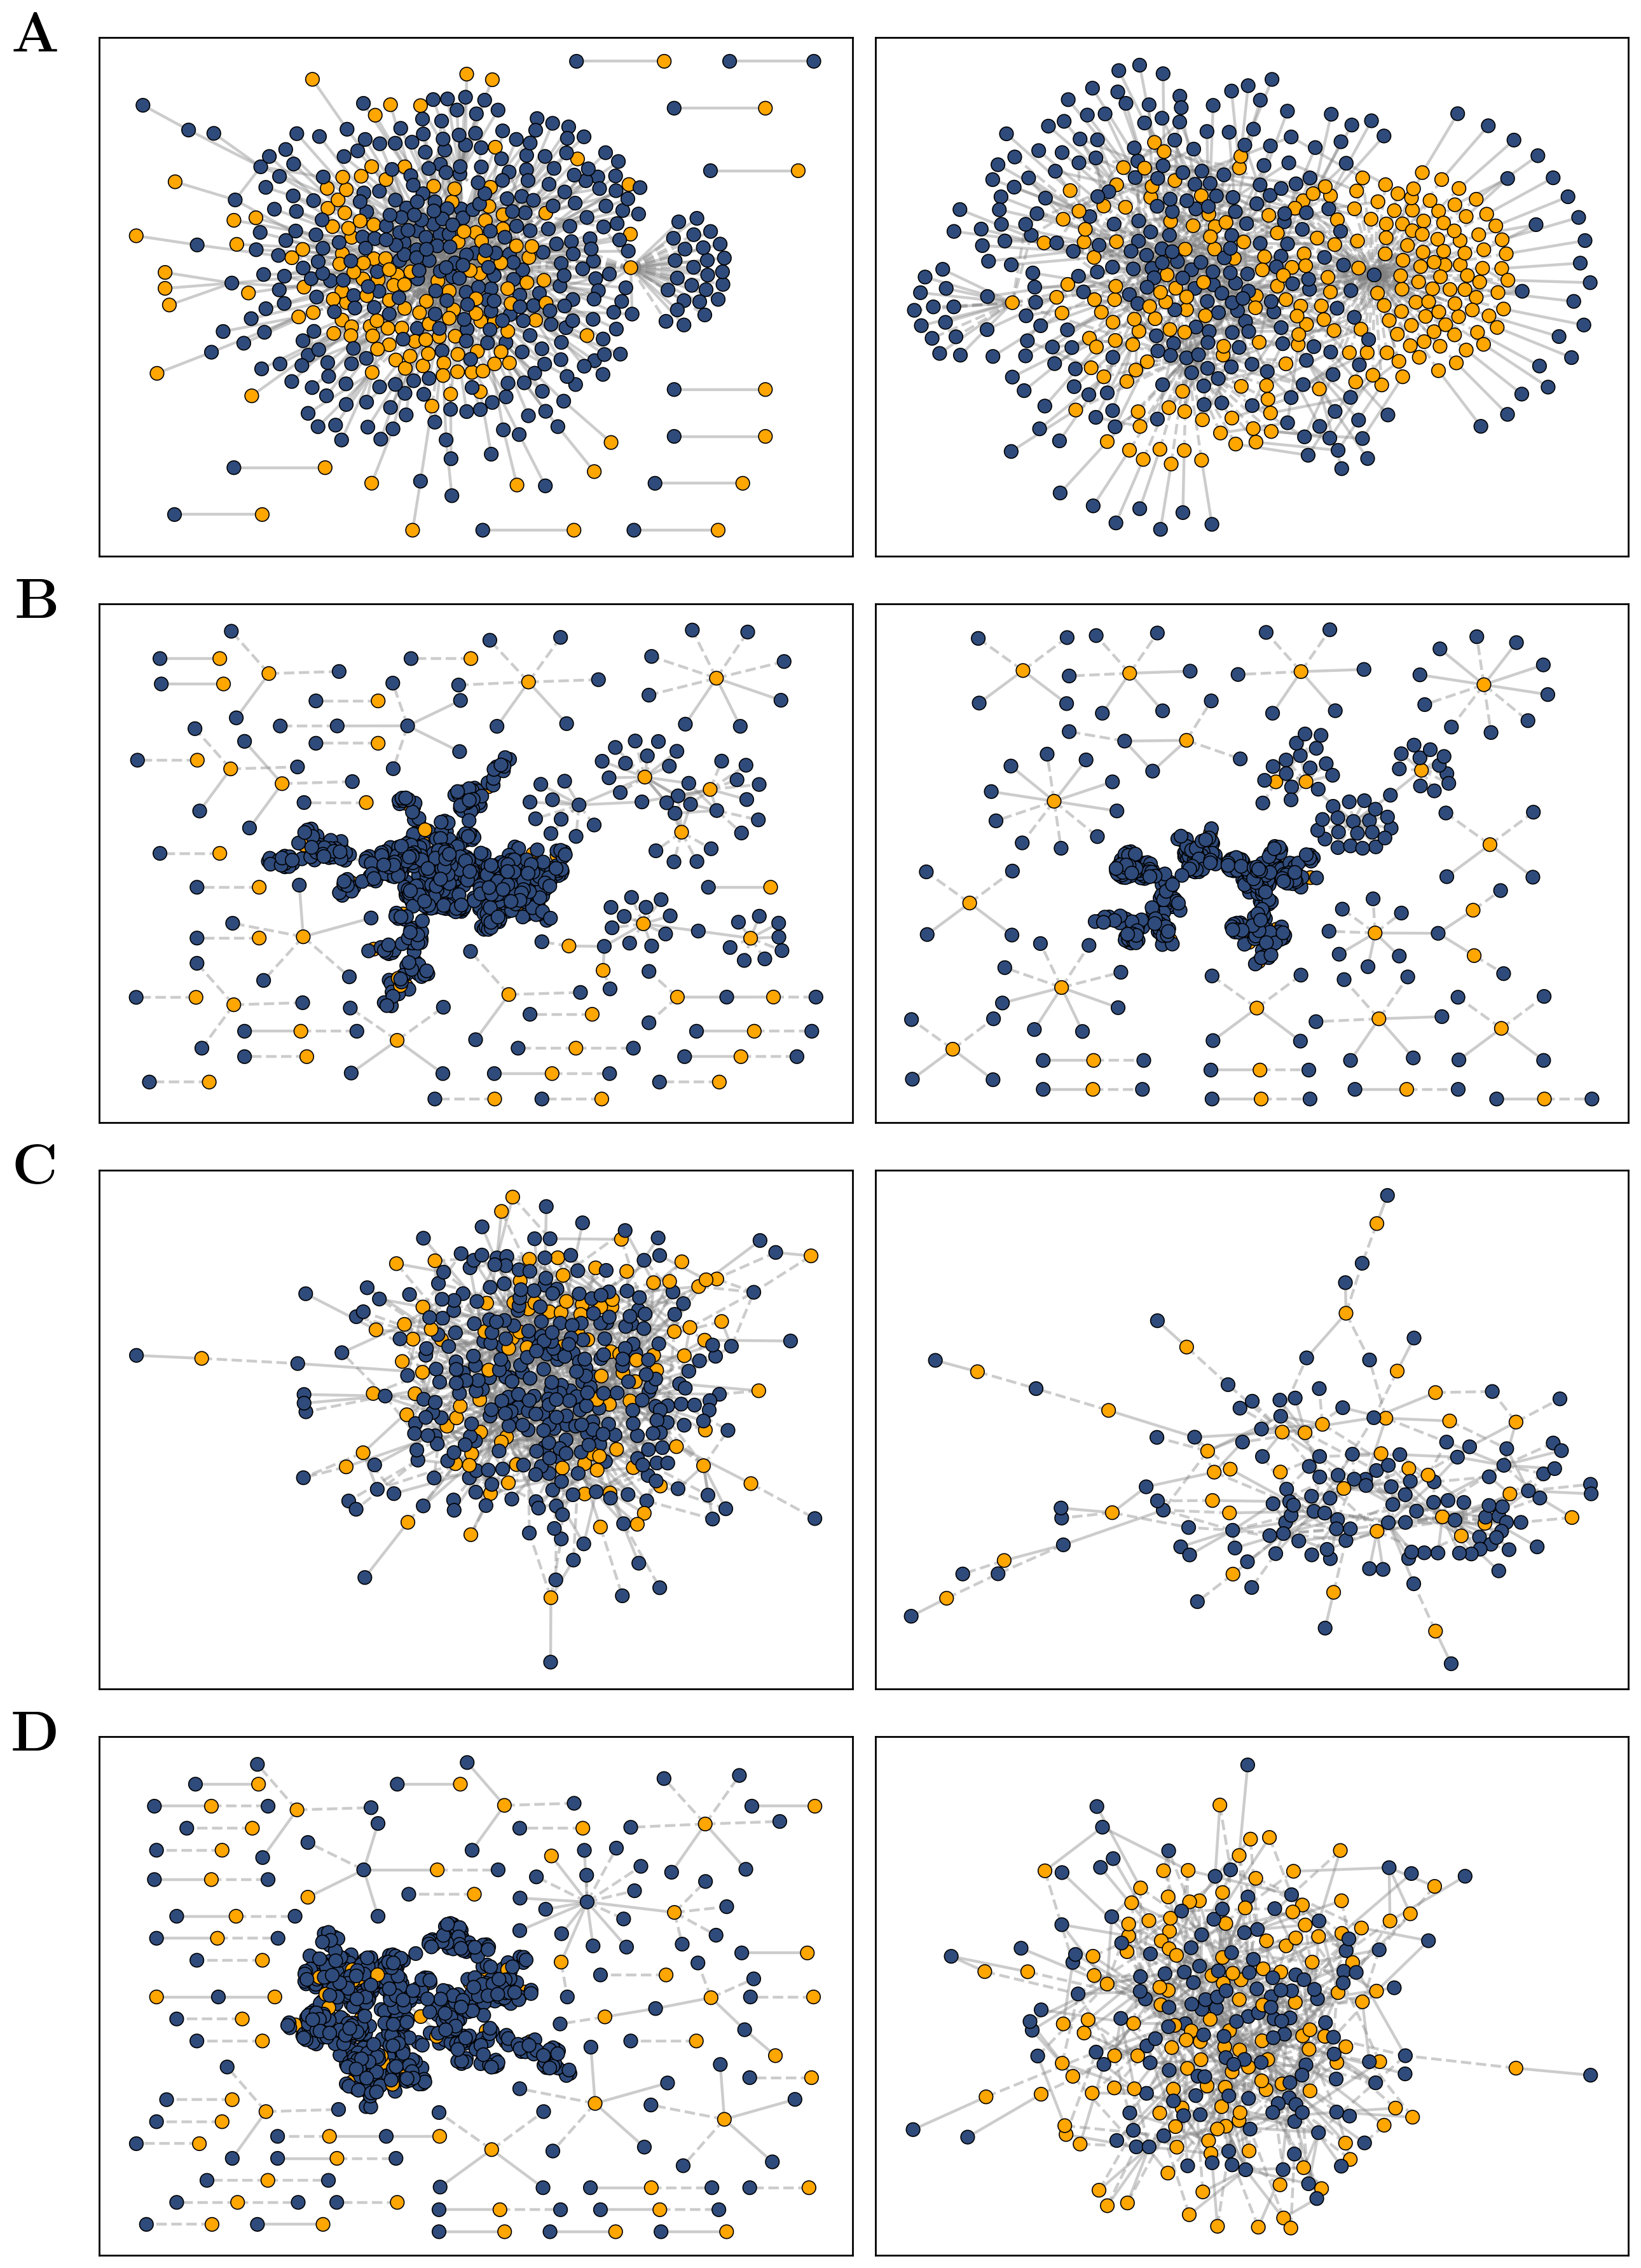

In [821]:
fig, ax = plt.subplots(4, 2, figsize=(6.5, 9))
labels = [r"\textbf{A}", r"\textbf{B}", r"\textbf{C}", r"\textbf{D}"]
for i in range(4):
    file = idx_files[list(idx_files.keys())[i]]
    graph = network(file, train=True)
    plot_graph(graph, ax[i, 0])
    graph = network(file, train=False)
    plot_graph(graph, ax[i, 1])
    ax[i, 0].set_xticks([])
    ax[i, 1].set_xticks([])   # Remove x-axis ticks
    ax[i, 0].set_yticks([]) 
    ax[i, 1].set_yticks([])
    ax[i, 0].annotate(labels[i],
                      xy=(-0.05, 1.0),
                      xycoords='axes fraction',
                      fontsize=16,
                      fontweight='bold',
                      va='center',
                      ha='right')

fig.set_facecolor("white")  # Set plot area background to white
plt.tight_layout() 
plt.savefig("media2/train_test_networks.pdf")
to_pgf("media2/train_test_networks.pgf")


In [25]:
import math 


In [26]:
k = 1
K = 2
n = 10
N = 22

math.comb(K,k) * math.comb((N-K), (n - k)) / math.comb(N, n)


0.5194805194805194

In [27]:
k = 5
K = 6
n = 10
N = 22

math.comb(K,k) * math.comb((N-K), (n - k)) / math.comb(N, n)


0.040529130312412044

# GO term results 


In [81]:
go_rand = Metrics("/home/llan/Desktop/WUR/thesis2/media2/binary/go/random_embedding")
go_real = Metrics("/home/llan/Desktop/WUR/thesis2/media2/binary/go/experimental")


In [82]:
go_rand.train


Dataset    Model   Tensor  Run  Epoch  Batch      Loss
0       Overlap   GO_ALL   go_all    0      0      0  0.700737
1       Overlap   GO_ALL   go_all    0      0      1  0.578062
2       Overlap   GO_ALL   go_all    0      0      2  0.547208
3       Overlap   GO_ALL   go_all    0      0      3  0.337385
4       Overlap   GO_ALL   go_all    0      0      4  0.389713
...         ...      ...      ...  ...    ...    ...       ...
14675  TG-split  GO_COMP  go_comp    9      3     25  0.141636
14676  TG-split  GO_COMP  go_comp    9      3     26  0.174282
14677  TG-split  GO_COMP  go_comp    9      3     27  0.104376
14678  TG-split  GO_COMP  go_comp    9      3     28  0.120685
14679  TG-split  GO_COMP  go_comp    9      3     29  0.123251

[14680 rows x 7 columns]

In [83]:
go_conv = {"GO_ALL": "All GO-terms", "GO_COMP": "w/o Comp", "GO_IEA": "w/o IEA" }


In [84]:
roc, prc = auc_scores(go_real.test)
roc = pd.DataFrame.from_dict(roc).melt()
roc["variable_1"] = roc["variable_1"].apply(lambda x: go_conv[x])


In [85]:
roc.head()


variable_0    variable_1     value
0    Overlap  All GO-terms  0.999843
1    Overlap  All GO-terms  0.999946
2    Overlap  All GO-terms  0.999934
3    Overlap  All GO-terms  0.999952
4    Overlap  All GO-terms  0.999952

In [86]:
def grouped_bar(df, pal="dark", height=3.25, aspect=1.0):
    # ax = plt.figure()
    g = sns.catplot(
        data=df, kind="bar",
        x="variable_0", y="value", hue="variable_1",
        errorbar="se", palette=pal, alpha=.6,
        facet_kws={"despine": False}, order=["Overlap", "TF-split", "TG-split", "TFTG-split"],
        capsize=.2,
        height=height,
        aspect=aspect
    )
    plt.axhline(y = 0.5, color = 'r', linestyle = '-.', alpha=0.8) 
    plt.ylim(0, 1.05)

    g.set_xlabels("Dataset")
    g.set_ylabels("AUROC (mean)")
    # g._legend.set_title("Model")
    sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.45, 0.98), ncol=3, title=None)


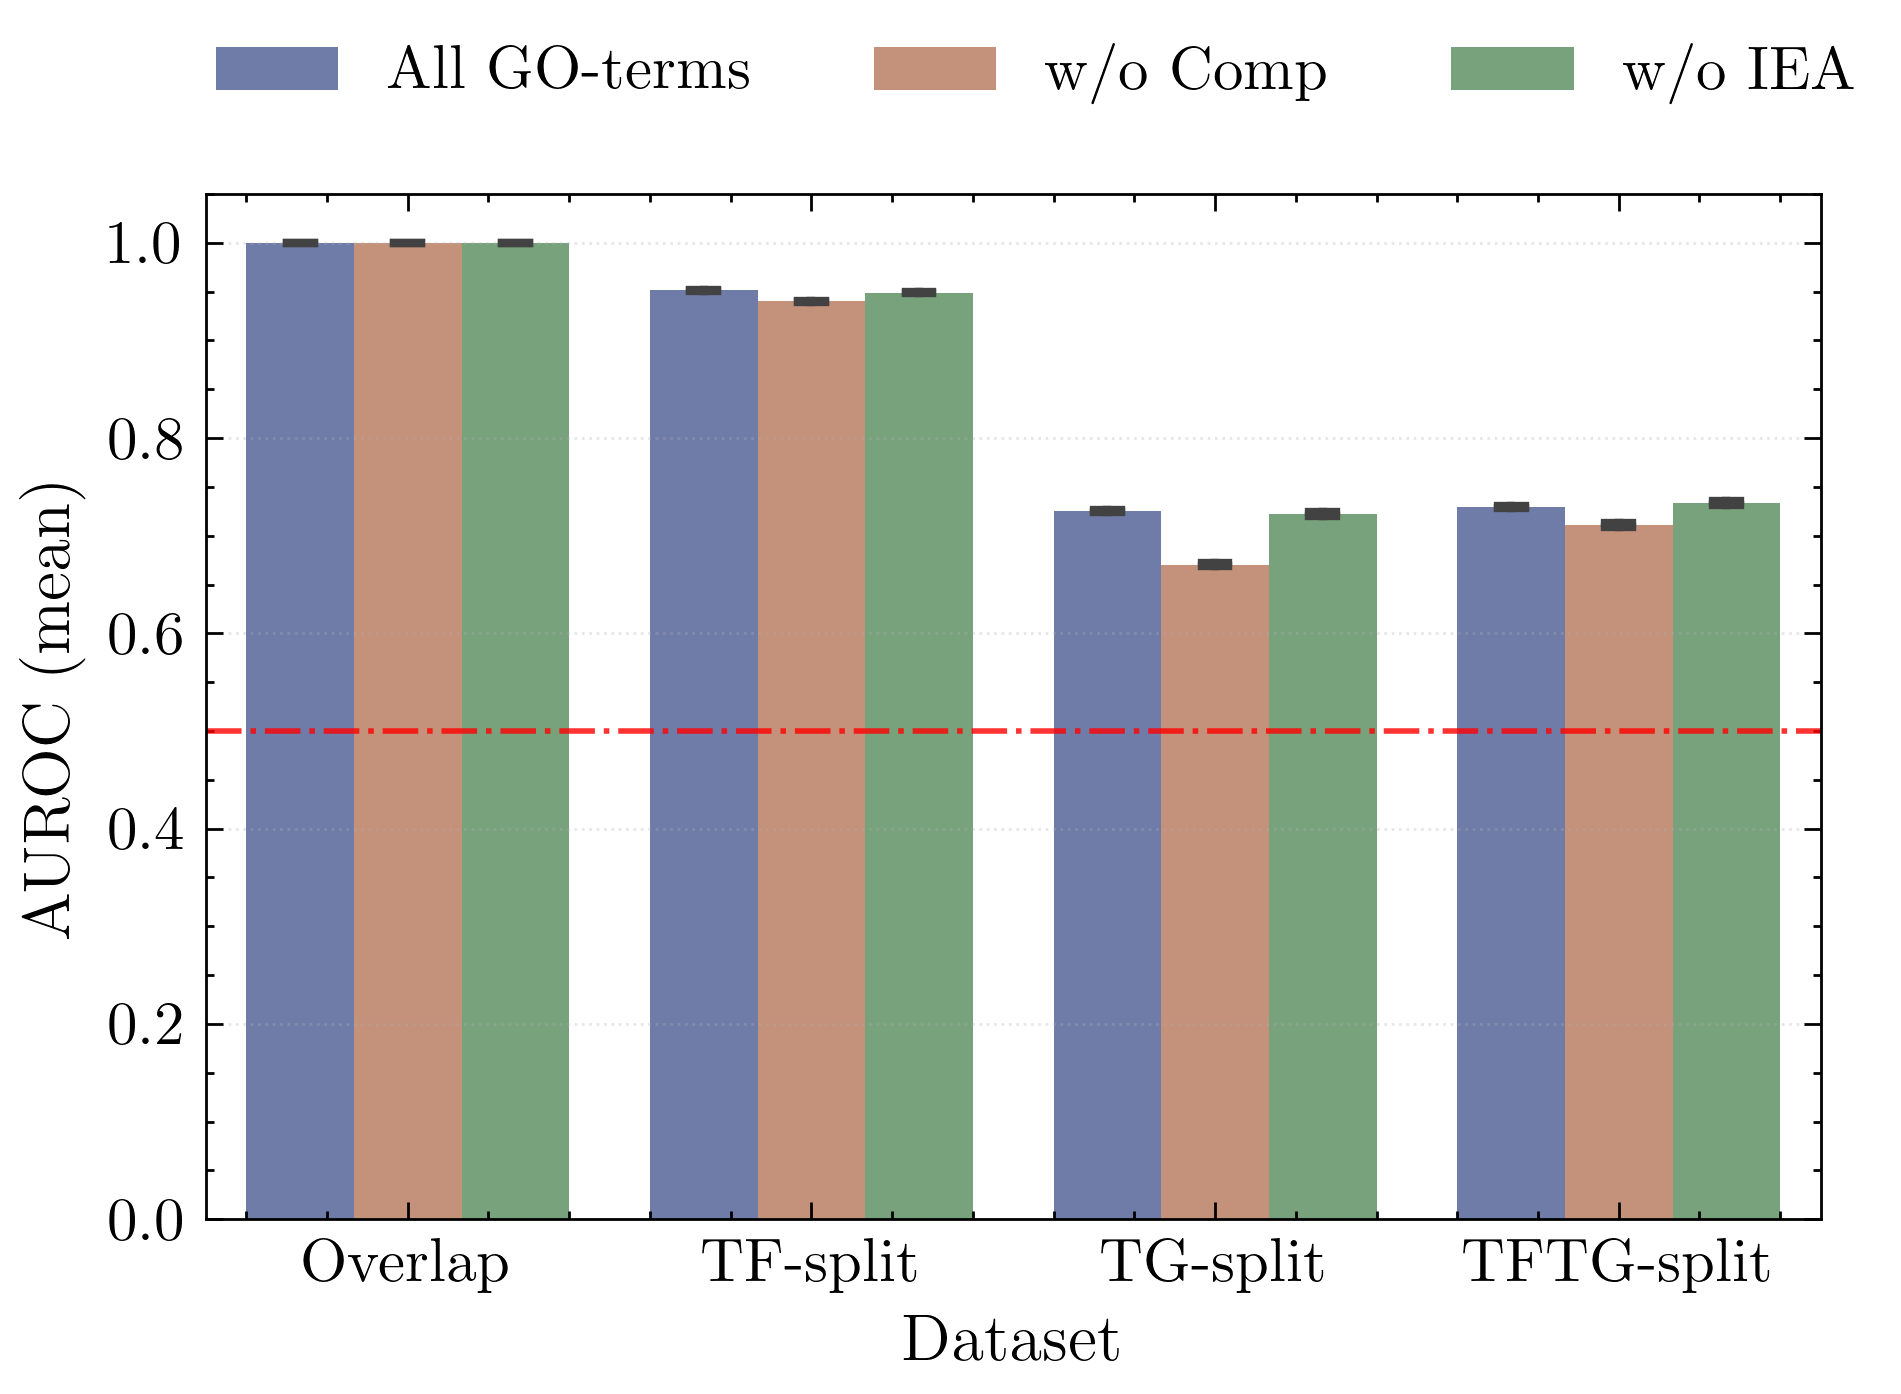

In [87]:

grouped_bar(roc, aspect=1.5)
to_pgf(go_real.dir.joinpath("GO_AUROC.pgf"))


# Single embedding

In [33]:
single_emb = Metrics("/home/llan/Desktop/WUR/thesis2/media2/binary/single_g2v_1000/")
double_emb = Metrics("/home/llan/Desktop/WUR/thesis2/media2/binary/double_embedding/double_g2v_1000/")


[0.25 0.25 0.25 0.25]


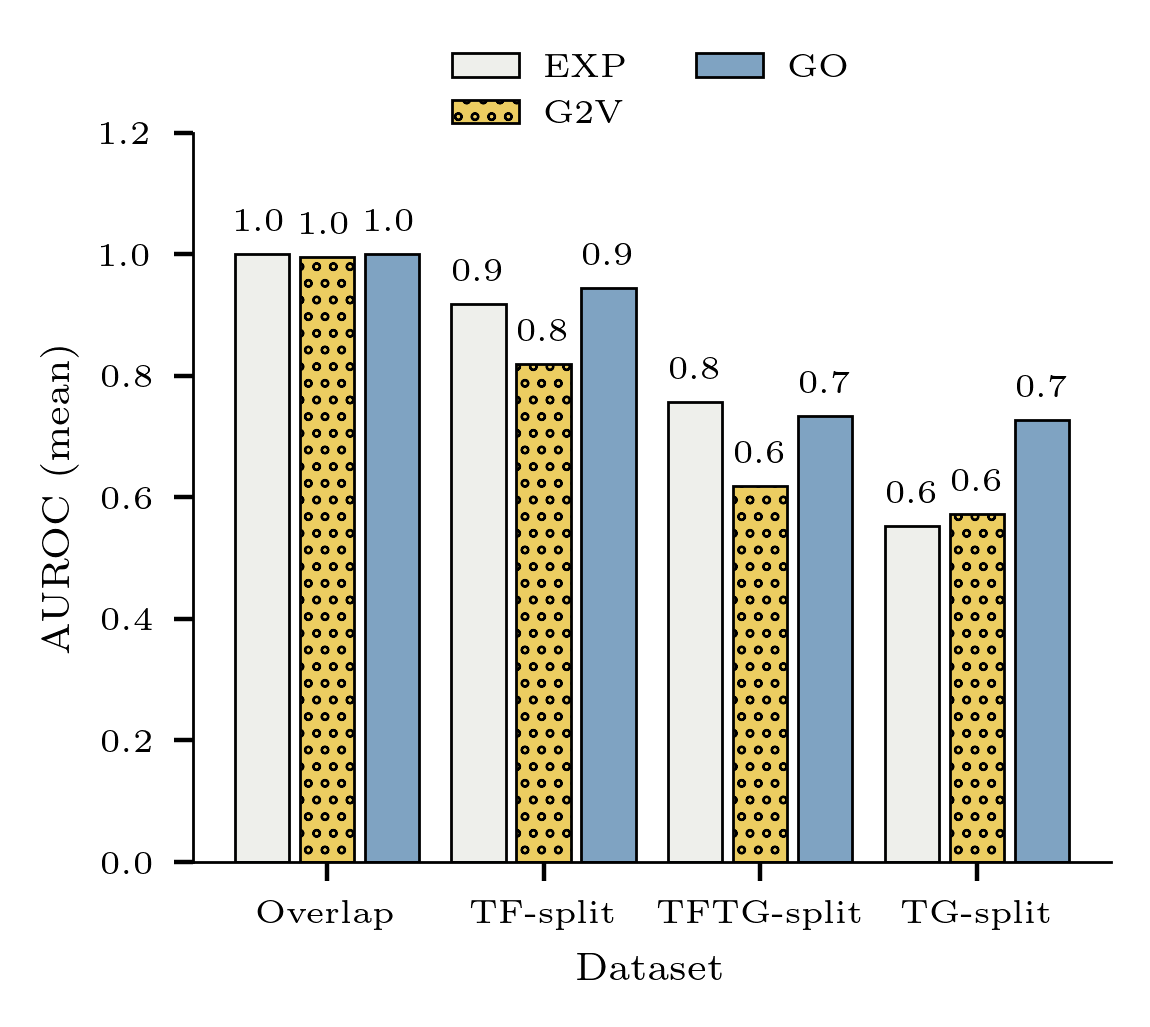

In [34]:
roc, prc = auc_scores(single_emb.test, ["Dataset", "Model"])
grouped_bar(roc)
# to_pgf(single_emb.dir.joinpath("single_AUROC.pgf"))
plt.savefig(single_emb.dir.joinpath("single_AUROC.pdf"))


In [35]:
print(df_from_auc(roc, prc).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXP & 1.000 & 0.000 & 1.000 & 0.000 \\
 & G2V & 0.996 & 0.000 & 0.993 & 0.000 \\
 & GO & 1.000 & 0.000 & 1.000 & 0.000 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXP & 0.917 & 0.002 & 0.929 & 0.002 \\
 & G2V & 0.819 & 0.002 & 0.792 & 0.003 \\
 & GO & 0.945 & 0.001 & 0.951 & 0.000 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXP & 0.756 & 0.007 & 0.772 & 0.006 \\
 & G2V & 0.618 & 0.005 & 0.613 & 0.007 \\
 & GO & 0.734 & 0.002 & 0.808 & 0.001 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXP & 0.553 & 0.006 & 0.545 & 0.008 \\
 & G2V & 0.573 & 0.004 & 0.591 & 0.004 \\
 & GO & 0.728 & 0.002 & 0.749 & 0.002 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [39]:
print((df_from_auc(roc, prc) - baseline_auc).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXP & 0.001 & 0.000 & 0.001 & 0.000 \\
 & G2V & -0.004 & 0.000 & -0.007 & 0.000 \\
 & GO & 0.000 & 0.000 & 0.000 & 0.000 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXP & 0.155 & -0.003 & 0.149 & -0.004 \\
 & G2V & 0.077 & -0.007 & 0.024 & -0.006 \\
 & GO & 0.125 & -0.001 & 0.080 & -0.002 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXP & 0.250 & -0.005 & 0.256 & -0.005 \\
 & G2V & 0.114 & -0.003 & 0.099 & -0.004 \\
 & GO & 0.221 & -0.008 & 0.287 & -0.009 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXP & 0.075 & -0.001 & 0.045 & 0.001 \\
 & G2V & 0.061 & -0.004 & 0.074 & -0.003 \\
 & GO & 0.229 & -0.004 & 0.254 & -0.005 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [23]:
print(performance_report(single_emb.test).to_latex(float_format="%.3f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Precision & Recall & F1-score & Accuracy \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXP & 0.991 & 0.992 & 0.991 & 0.992 \\
 & G2V & 0.990 & 0.990 & 0.990 & 0.990 \\
 & GO & 0.997 & 0.988 & 0.993 & 0.993 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXP & 0.863 & 0.823 & 0.843 & 0.846 \\
 & G2V & 0.743 & 0.754 & 0.749 & 0.747 \\
 & GO & 0.869 & 0.875 & 0.872 & 0.871 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXP & 0.536 & 0.677 & 0.598 & 0.545 \\
 & G2V & 0.524 & 0.732 & 0.611 & 0.534 \\
 & GO & 0.572 & 0.844 & 0.682 & 0.606 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXP & 0.690 & 0.670 & 0.680 & 0.684 \\
 & G2V & 0.592 & 0.611 & 0.601 & 0.595 \\
 & GO & 0.710 & 0.629 & 0.667 & 0.686 \\
\cline{1-6}
\bottomrule
\end{tabular}



# double embedding

[0.25 0.25 0.25]


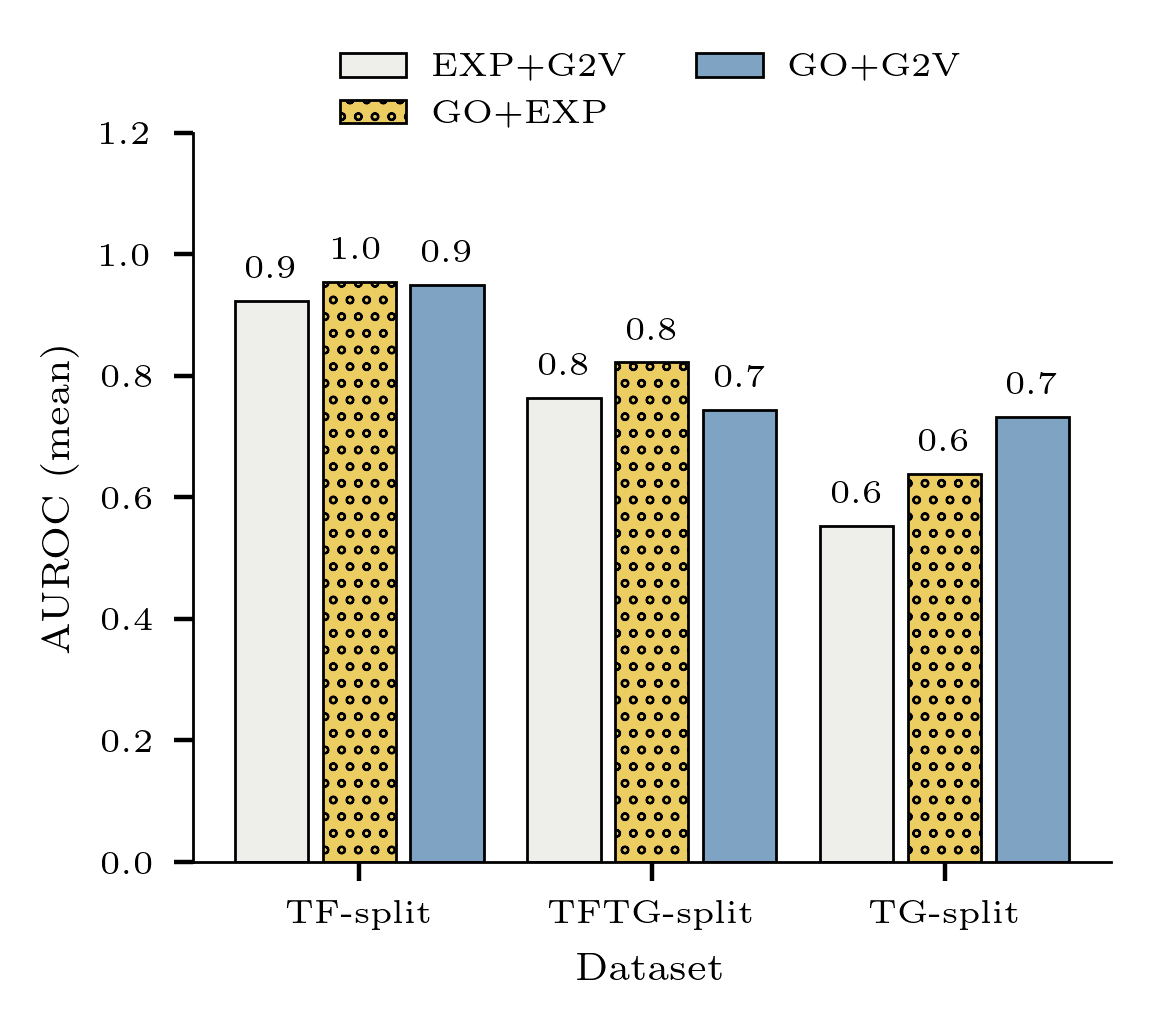

In [40]:
roc, prc = auc_scores(double_emb.test.loc[double_emb.test.Dataset != "Overlap"].replace({"EXPG2V": "EXP+G2V", "GOG2V": "GO+G2V", "GOEXP": "GO+EXP"}), ["Dataset", "Model"])
grouped_bar(roc)
plt.savefig(double_emb.dir.joinpath("double_AUROC.pdf"))


In [41]:
print(performance_report(double_emb.test).to_latex(float_format="%.3f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Precision & Recall & F1-score & Accuracy \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXPG2V & 0.992 & 0.996 & 0.994 & 0.995 \\
 & GOEXP & 0.992 & 0.994 & 0.993 & 0.994 \\
 & GOG2V & 0.999 & 0.999 & 0.999 & 0.999 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXPG2V & 0.862 & 0.831 & 0.846 & 0.849 \\
 & GOEXP & 0.906 & 0.875 & 0.890 & 0.892 \\
 & GOG2V & 0.901 & 0.862 & 0.881 & 0.884 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXPG2V & 0.531 & 0.665 & 0.590 & 0.539 \\
 & GOEXP & 0.551 & 0.841 & 0.666 & 0.578 \\
 & GOG2V & 0.556 & 0.882 & 0.682 & 0.589 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXPG2V & 0.685 & 0.697 & 0.691 & 0.688 \\
 & GOEXP & 0.729 & 0.743 & 0.736 & 0.733 \\
 & GOG2V & 0.736 & 0.629 & 0.679 & 0.702 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [43]:
print(df_from_auc(*(auc_scores(double_emb.test, ["Dataset", "Model"]))).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Overlap} & EXPG2V & 1.00 & 0.00 & 1.00 & 0.00 \\
 & GOEXP & 1.00 & 0.00 & 1.00 & 0.00 \\
 & GOG2V & 1.00 & 0.00 & 1.00 & 0.00 \\
\cline{1-6}
\multirow[t]{3}{*}{TF-split} & EXPG2V & 0.92 & 0.00 & 0.93 & 0.00 \\
 & GOEXP & 0.95 & 0.00 & 0.96 & 0.00 \\
 & GOG2V & 0.95 & 0.00 & 0.95 & 0.00 \\
\cline{1-6}
\multirow[t]{3}{*}{TFTG-split} & EXPG2V & 0.76 & 0.01 & 0.77 & 0.01 \\
 & GOEXP & 0.82 & 0.00 & 0.85 & 0.01 \\
 & GOG2V & 0.74 & 0.00 & 0.81 & 0.00 \\
\cline{1-6}
\multirow[t]{3}{*}{TG-split} & EXPG2V & 0.55 & 0.00 & 0.55 & 0.00 \\
 & GOEXP & 0.64 & 0.01 & 0.63 & 0.01 \\
 & GOG2V & 0.73 & 0.00 & 0.76 & 0.00 \\
\cline{1-6}
\bottomrule
\end{tabular}



0 0 ('Overlap', 'EXPG2V')
0 1 ('Overlap', 'GOEXP')
0 2 ('Overlap', 'GOG2V')
1 0 ('TF-split', 'EXPG2V')
1 1 ('TF-split', 'GOEXP')
1 2 ('TF-split', 'GOG2V')
2 0 ('TFTG-split', 'EXPG2V')
2 1 ('TFTG-split', 'GOEXP')
2 2 ('TFTG-split', 'GOG2V')
3 0 ('TG-split', 'EXPG2V')
3 1 ('TG-split', 'GOEXP')
3 2 ('TG-split', 'GOG2V')
['EXPG2V', 'GOEXP', 'GOG2V']


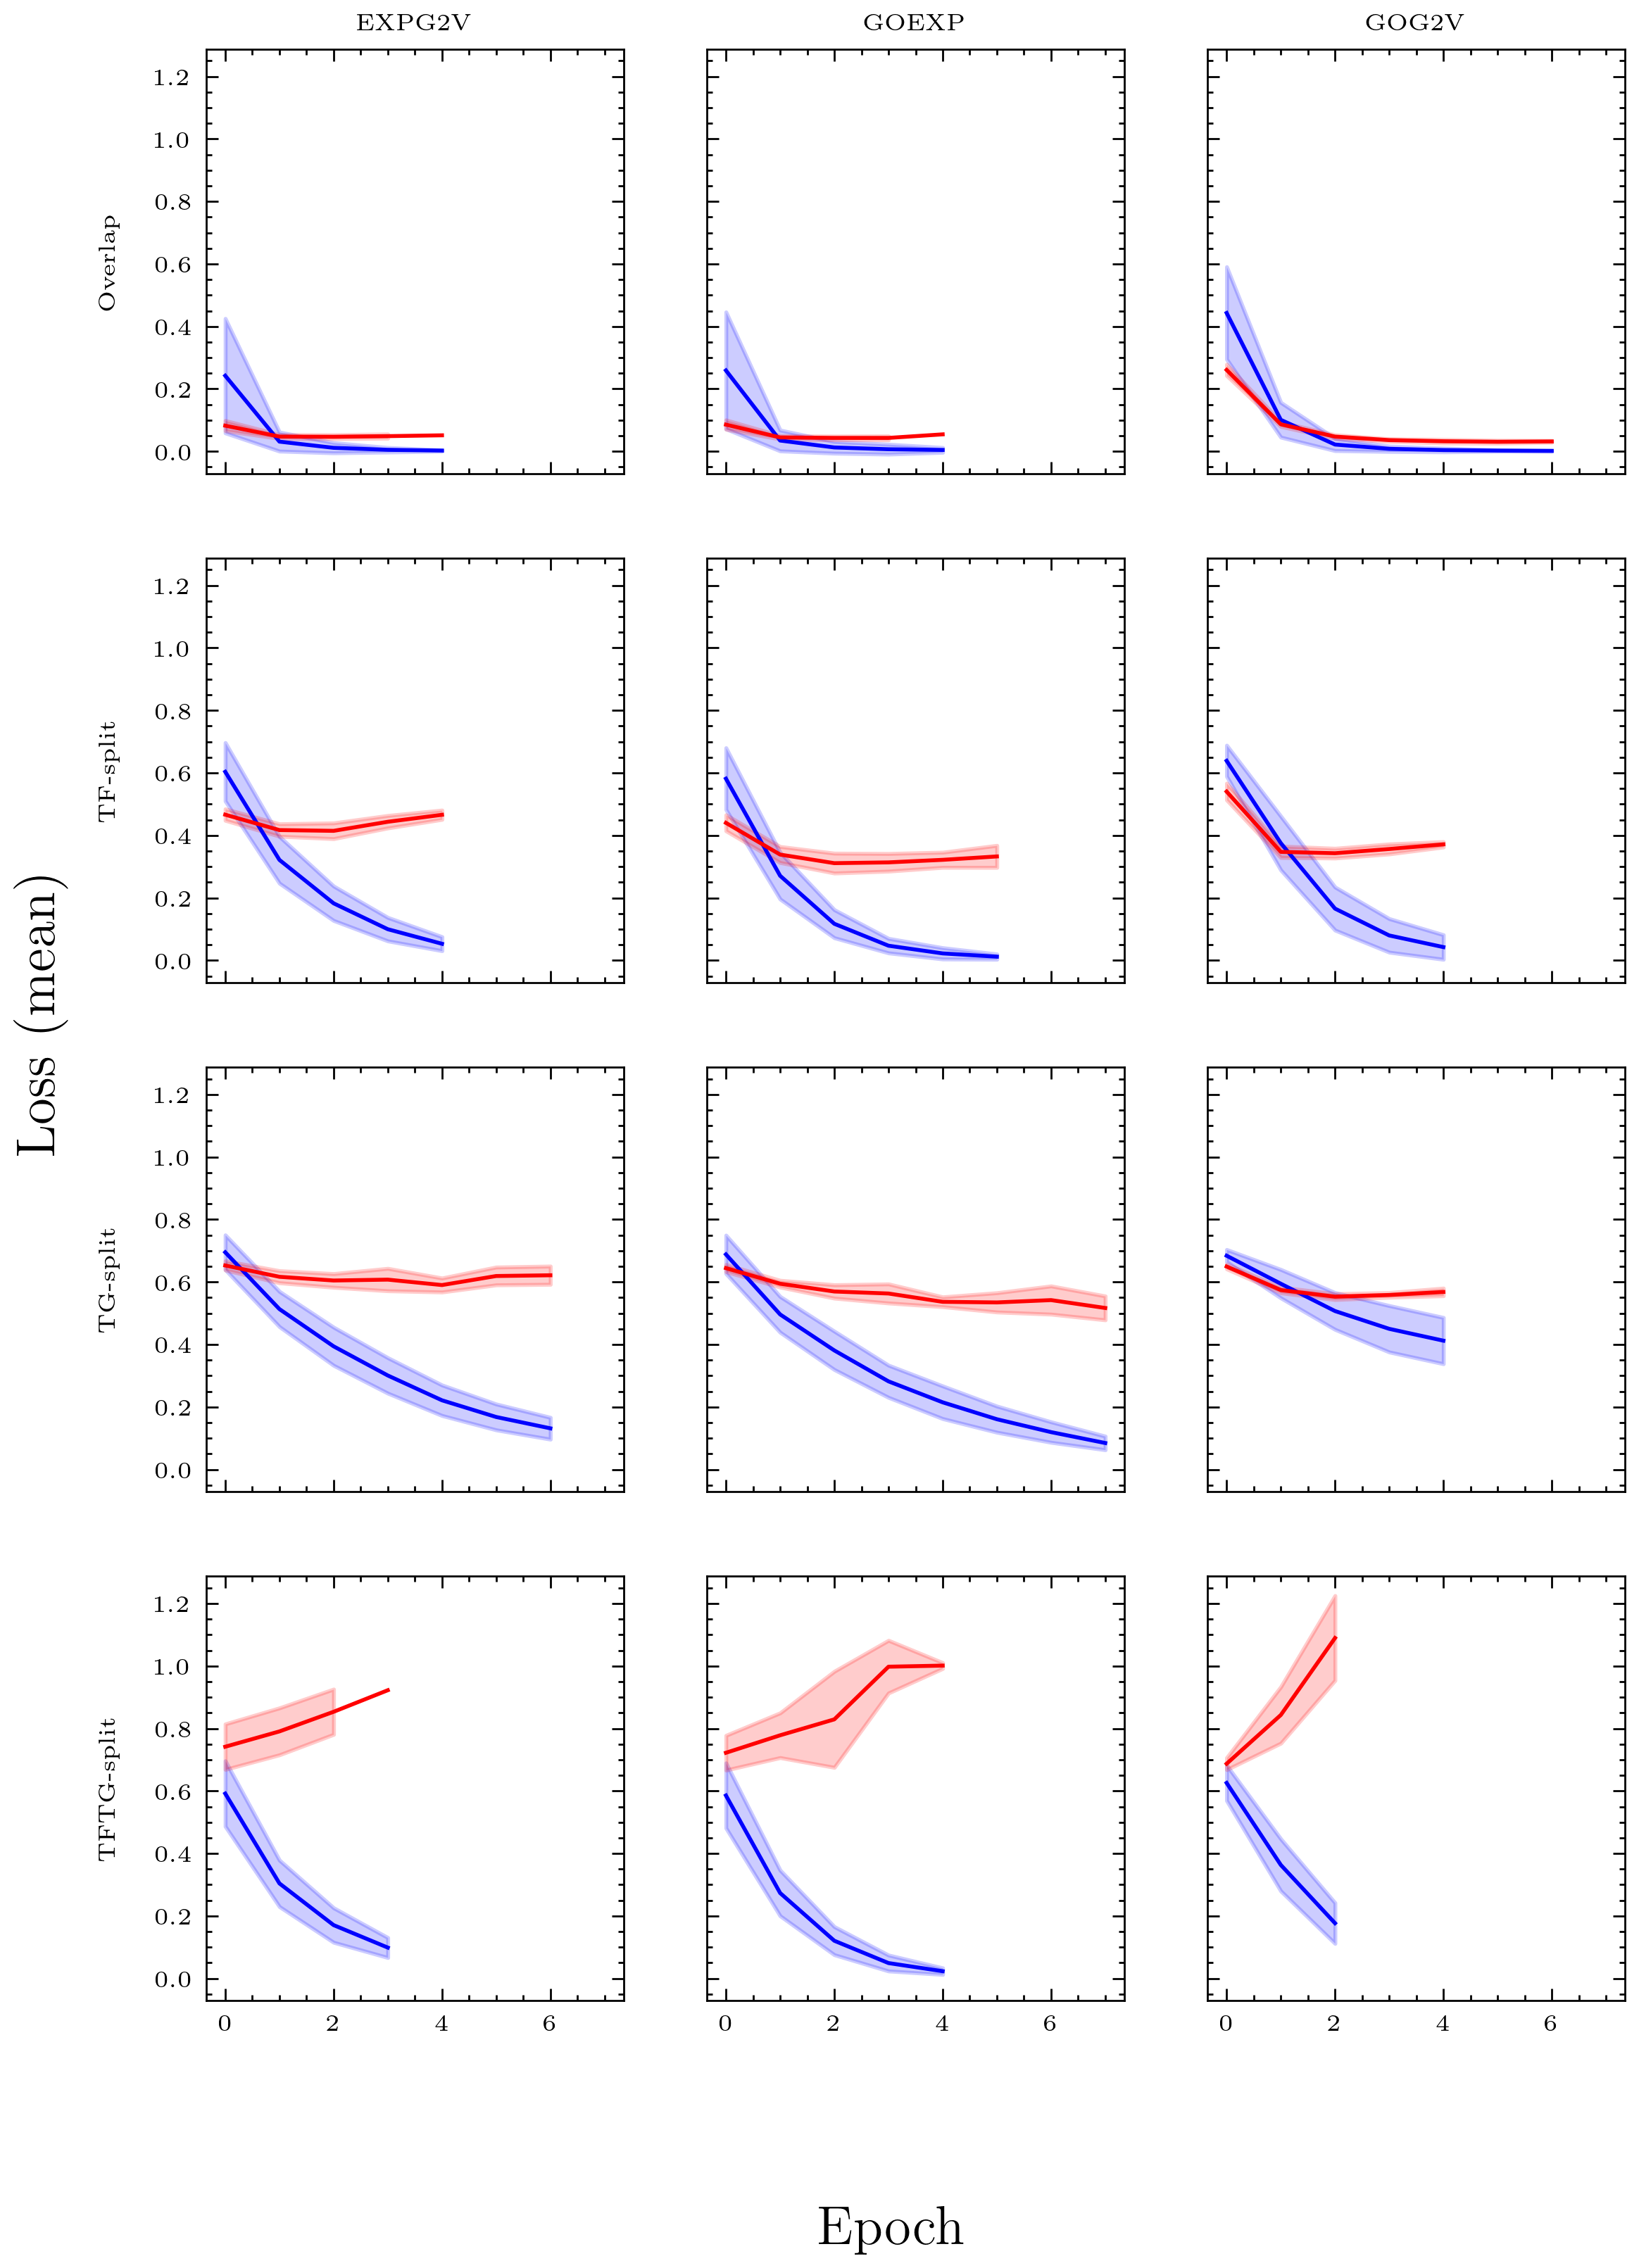

In [815]:
plt.style.use("science")
loss_plot(double_emb.train, double_emb.val)


# triple embedding


In [809]:
tri_rand  = Metrics("media2/binary/triple_embedding/random")
tri = Metrics("media2/binary/triple_embedding")


[0.   0.35 0.7 ]


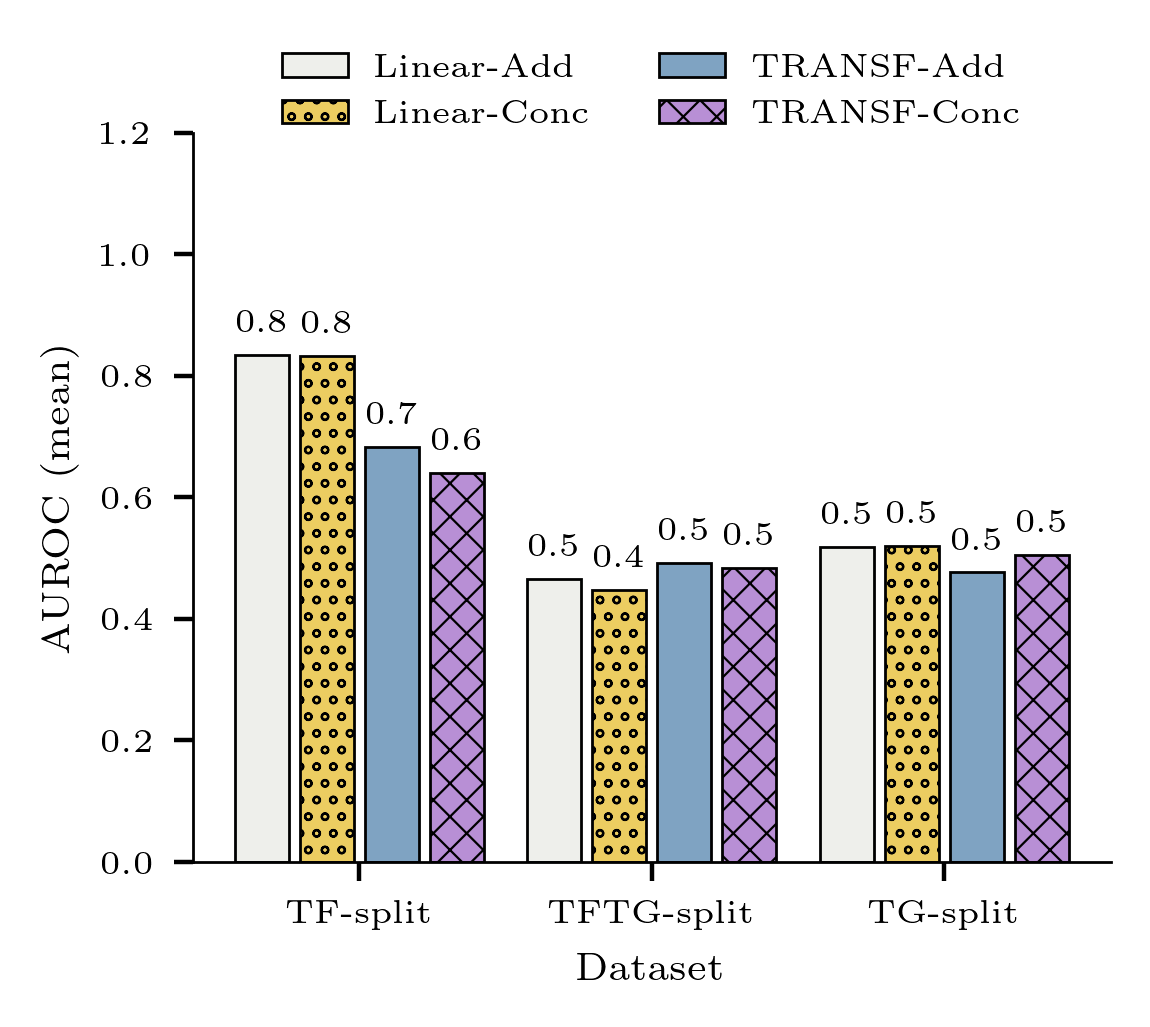

In [810]:
roc, prc = auc_scores(tri_rand.test.loc[tri_rand.test.Dataset != "Overlap"], ["Dataset", "Model"])
grouped_bar(roc)


[0.   0.35 0.7 ]


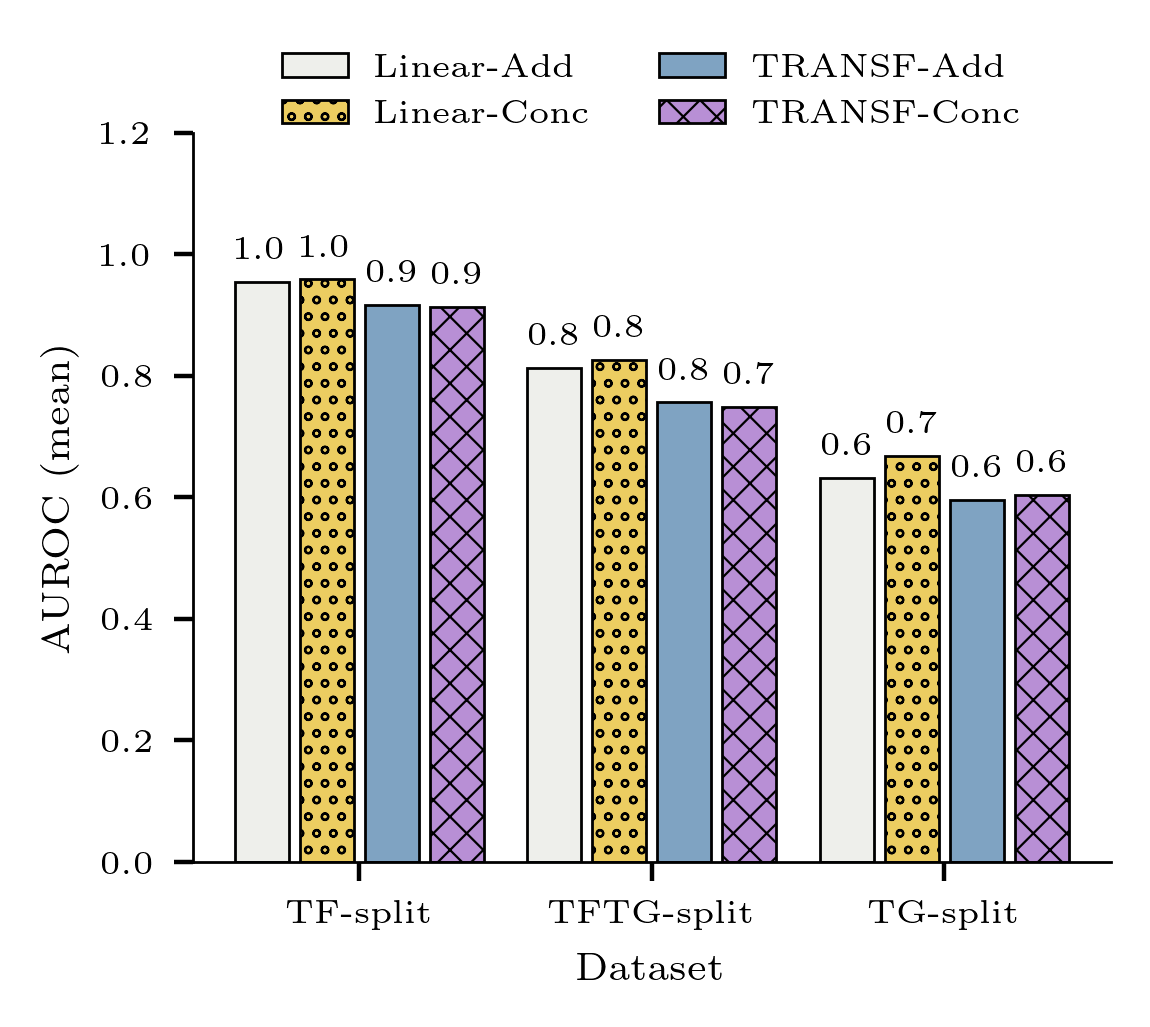

In [811]:
roc, prc = auc_scores(tri.test.loc[tri.test.Dataset != "Overlap"], ["Dataset", "Model"])
grouped_bar(roc)
plt.savefig(tri.dir.joinpath("AUROC_triple.pdf"))

In [812]:
print(performance_report(tri.test).to_latex(float_format= "%.3f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Precision & Recall & F1-score & Accuracy \\
\midrule
\multirow[t]{4}{*}{Overlap} & Linear-Add & 0.993 & 0.996 & 0.994 & 0.995 \\
 & Linear-Conc & 0.992 & 0.997 & 0.995 & 0.995 \\
 & TRANSF-Add & 0.988 & 0.991 & 0.989 & 0.990 \\
 & TRANSF-Conc & 0.988 & 0.986 & 0.987 & 0.988 \\
\cline{1-6}
\multirow[t]{4}{*}{TF-split} & Linear-Add & 0.907 & 0.870 & 0.888 & 0.890 \\
 & Linear-Conc & 0.906 & 0.881 & 0.893 & 0.895 \\
 & TRANSF-Add & 0.873 & 0.835 & 0.854 & 0.857 \\
 & TRANSF-Conc & 0.852 & 0.839 & 0.846 & 0.847 \\
\cline{1-6}
\multirow[t]{4}{*}{TG-split} & Linear-Add & 0.549 & 0.814 & 0.656 & 0.573 \\
 & Linear-Conc & 0.551 & 0.882 & 0.678 & 0.582 \\
 & TRANSF-Add & 0.536 & 0.781 & 0.636 & 0.553 \\
 & TRANSF-Conc & 0.543 & 0.787 & 0.643 & 0.563 \\
\cline{1-6}
\multirow[t]{4}{*}{TFTG-split} & Linear-Add & 0.734 & 0.708 & 0.721 & 0.726 \\
 & Linear-Conc & 0.759 & 0.729 & 0.744 & 0.749 \\
 & TRANSF-Add & 0.651 & 0.734 & 0.690 & 0.670 \\
 & TRANSF-Conc & 

In [813]:
print(df_from_auc(roc, prc).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{TF-split} & Linear-Add & 0.954 & 0.001 & 0.963 & 0.001 \\
 & Linear-Conc & 0.958 & 0.000 & 0.966 & 0.000 \\
 & TRANSF-Add & 0.917 & 0.006 & 0.929 & 0.007 \\
 & TRANSF-Conc & 0.913 & 0.006 & 0.930 & 0.006 \\
\cline{1-6}
\multirow[t]{4}{*}{TFTG-split} & Linear-Add & 0.813 & 0.006 & 0.841 & 0.006 \\
 & Linear-Conc & 0.825 & 0.005 & 0.859 & 0.004 \\
 & TRANSF-Add & 0.756 & 0.012 & 0.797 & 0.009 \\
 & TRANSF-Conc & 0.749 & 0.014 & 0.783 & 0.017 \\
\cline{1-6}
\multirow[t]{4}{*}{TG-split} & Linear-Add & 0.631 & 0.004 & 0.630 & 0.009 \\
 & Linear-Conc & 0.667 & 0.004 & 0.671 & 0.007 \\
 & TRANSF-Add & 0.595 & 0.008 & 0.581 & 0.011 \\
 & TRANSF-Conc & 0.604 & 0.011 & 0.594 & 0.016 \\
\cline{1-6}
\bottomrule
\end{tabular}



0 0 ('Overlap', 'Linear-Add')
0 1 ('Overlap', 'Linear-Conc')
0 2 ('Overlap', 'TRANSF-Add')
0 3 ('Overlap', 'TRANSF-Conc')
1 0 ('TF-split', 'Linear-Add')
1 1 ('TF-split', 'Linear-Conc')
1 2 ('TF-split', 'TRANSF-Add')
1 3 ('TF-split', 'TRANSF-Conc')
2 0 ('TFTG-split', 'Linear-Add')
2 1 ('TFTG-split', 'Linear-Conc')
2 2 ('TFTG-split', 'TRANSF-Add')
2 3 ('TFTG-split', 'TRANSF-Conc')
3 0 ('TG-split', 'Linear-Add')
3 1 ('TG-split', 'Linear-Conc')
3 2 ('TG-split', 'TRANSF-Add')
3 3 ('TG-split', 'TRANSF-Conc')
['Linear-Add', 'Linear-Conc', 'TRANSF-Add', 'TRANSF-Conc']


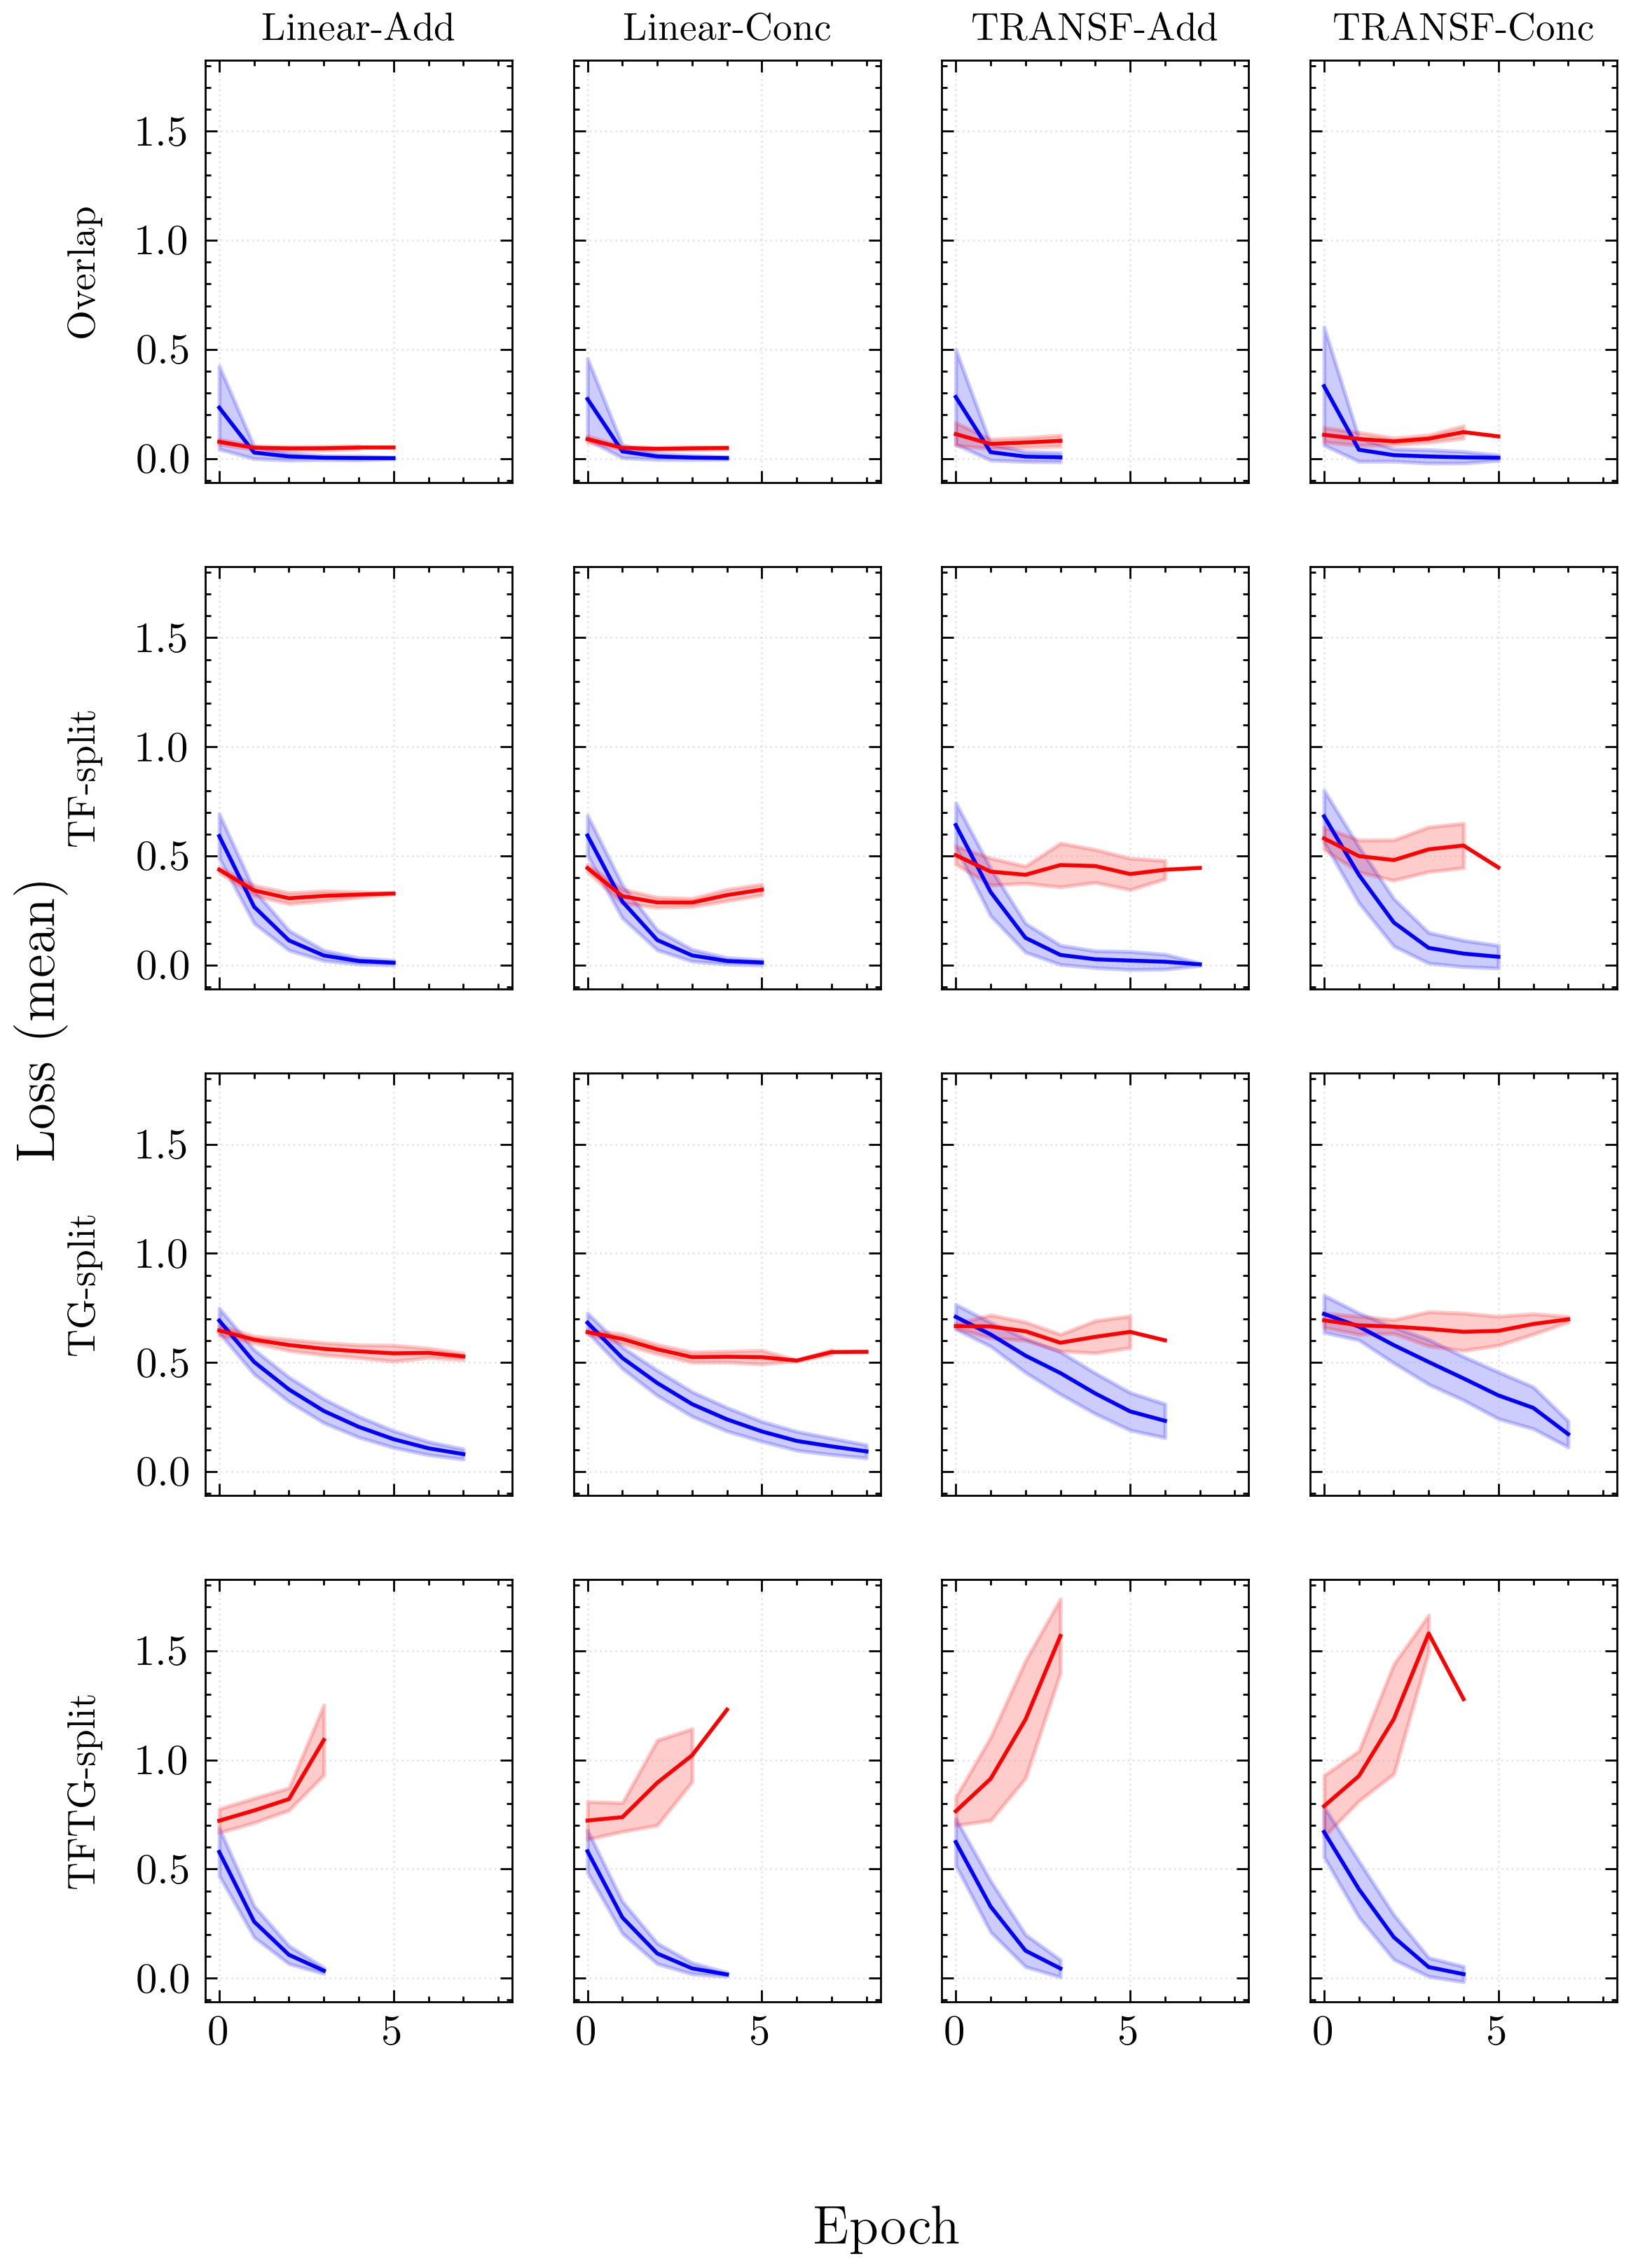

In [38]:
loss_plot(tri.train, tri.val)


[]
0 0 ('Overlap', 'Linear-Add')
0 1 ('Overlap', 'Linear-Conc')
0 2 ('Overlap', 'TRANSF-Add')
0 3 ('Overlap', 'TRANSF-Conc')
1 0 ('TF-split', 'Linear-Add')
1 1 ('TF-split', 'Linear-Conc')
1 2 ('TF-split', 'TRANSF-Add')
1 3 ('TF-split', 'TRANSF-Conc')
2 0 ('TFTG-split', 'Linear-Add')
2 1 ('TFTG-split', 'Linear-Conc')
2 2 ('TFTG-split', 'TRANSF-Add')
2 3 ('TFTG-split', 'TRANSF-Conc')
3 0 ('TG-split', 'Linear-Add')
3 1 ('TG-split', 'Linear-Conc')
3 2 ('TG-split', 'TRANSF-Add')
3 3 ('TG-split', 'TRANSF-Conc')


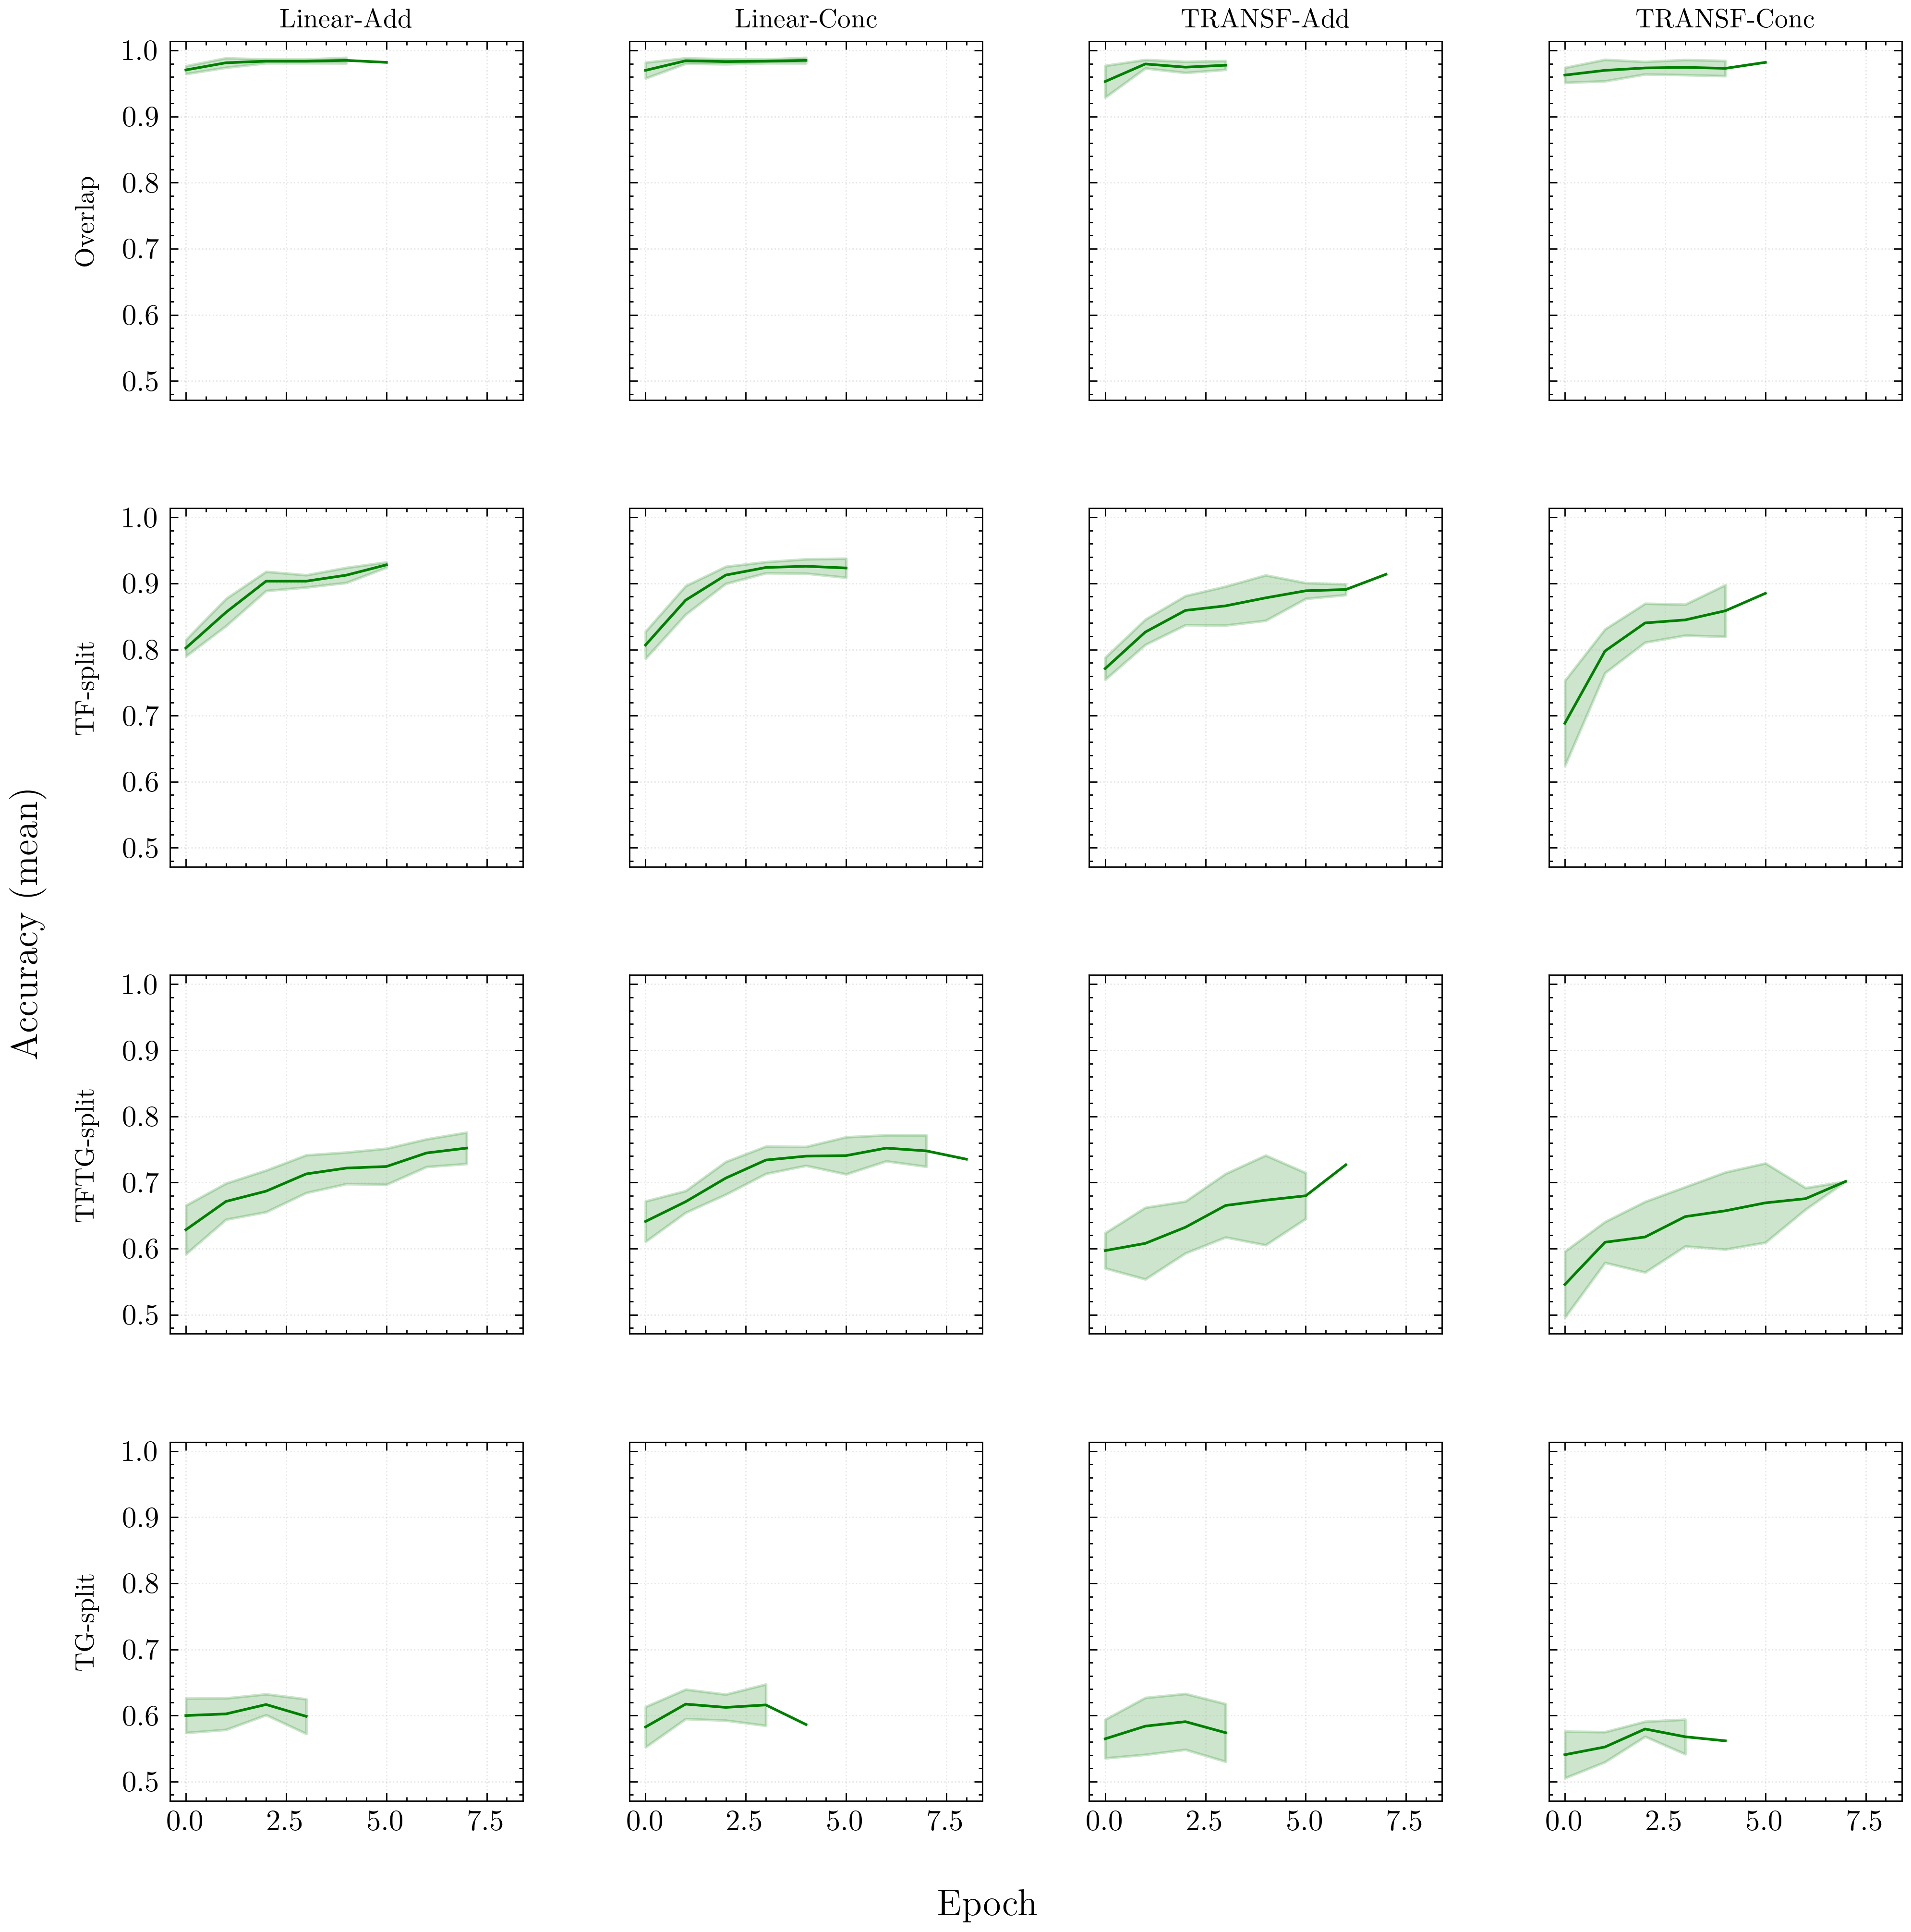

In [39]:
acc_plot(tri.val)


# vector length 

In [548]:
data = Metrics("media2/base_line/vector_length")


In [549]:
def auc_scores(test_df):
    roc_scores = defaultdict(list)
    prc_scores = defaultdict(list)

    for name, frame in test_df.groupby(["Dataset", "VectorSize", "Run"]):
        name = name[:2]
        #frame["pred_label"] = (frame.Pred >= 0.5).astype(int)
        roc_scores[name].append(metric.roc_auc_score(frame.Label, frame.Pred))

        precision, recall, _ = metric.precision_recall_curve(frame.Label, frame.Pred)

        prc_scores[name].append(metric.auc(recall, precision))
    return roc_scores, prc_scores


In [550]:
roc, prc = auc_scores(data.test)


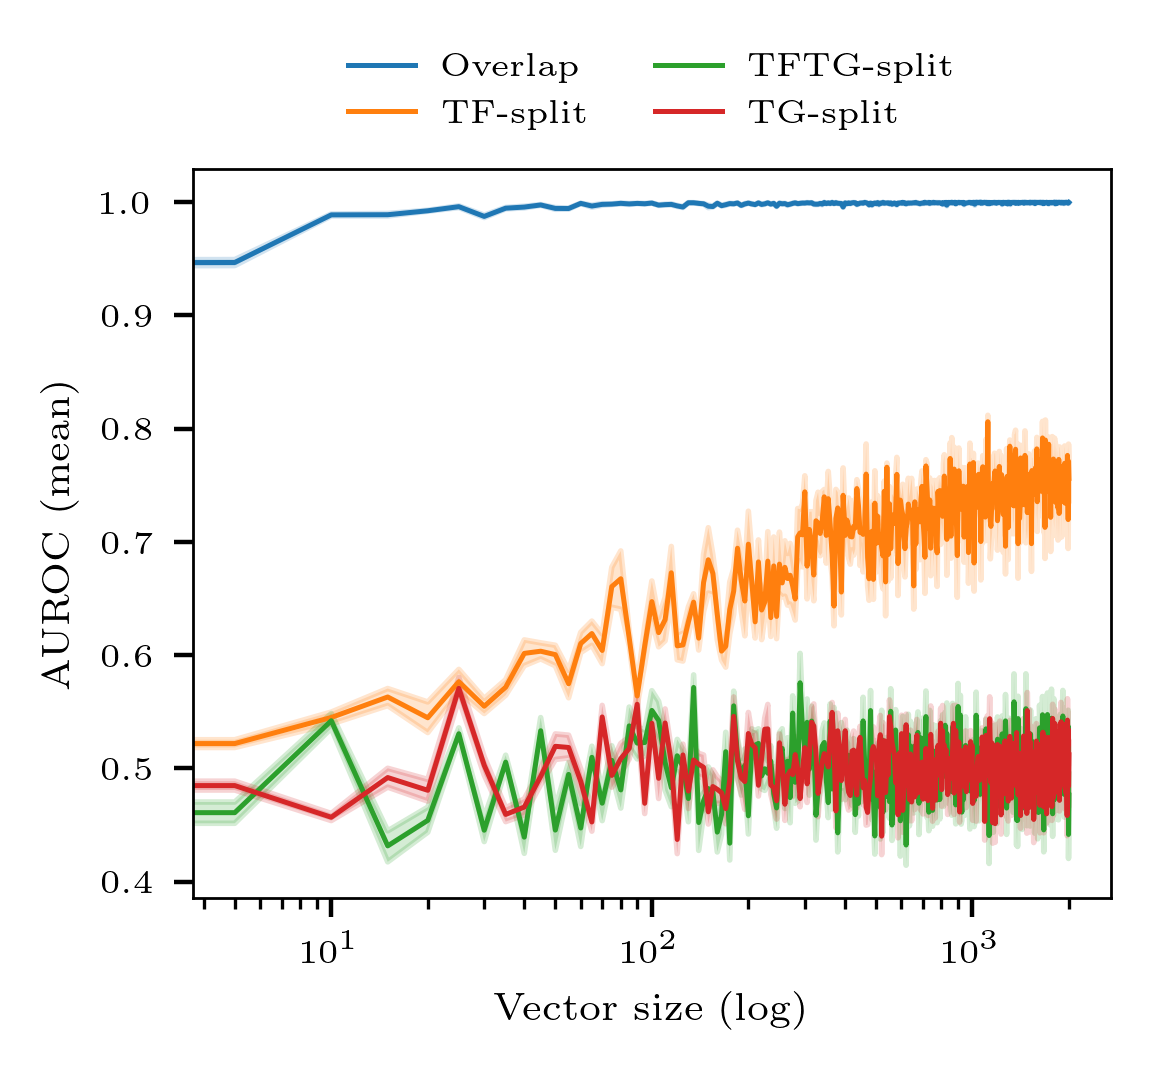

In [552]:
roc_df = pd.DataFrame(roc).melt()
roc_df.columns = ["Dataset", "VectorSize", "AUROC (mean)"]

fig, ax = plt.subplots()
g = sns.lineplot(data=roc_df, x="VectorSize", y="AUROC (mean)", hue="Dataset", ax=ax, palette="tab10")
g.set_xscale("log")
g.set_xlabel("Vector size (log)")
plt.legend(bbox_to_anchor=(0.5, 1.20), loc="upper center", ncol=2, frameon=False)
to_pgf("media2/base_line/vector_length/continuous_vector_length.pgf")


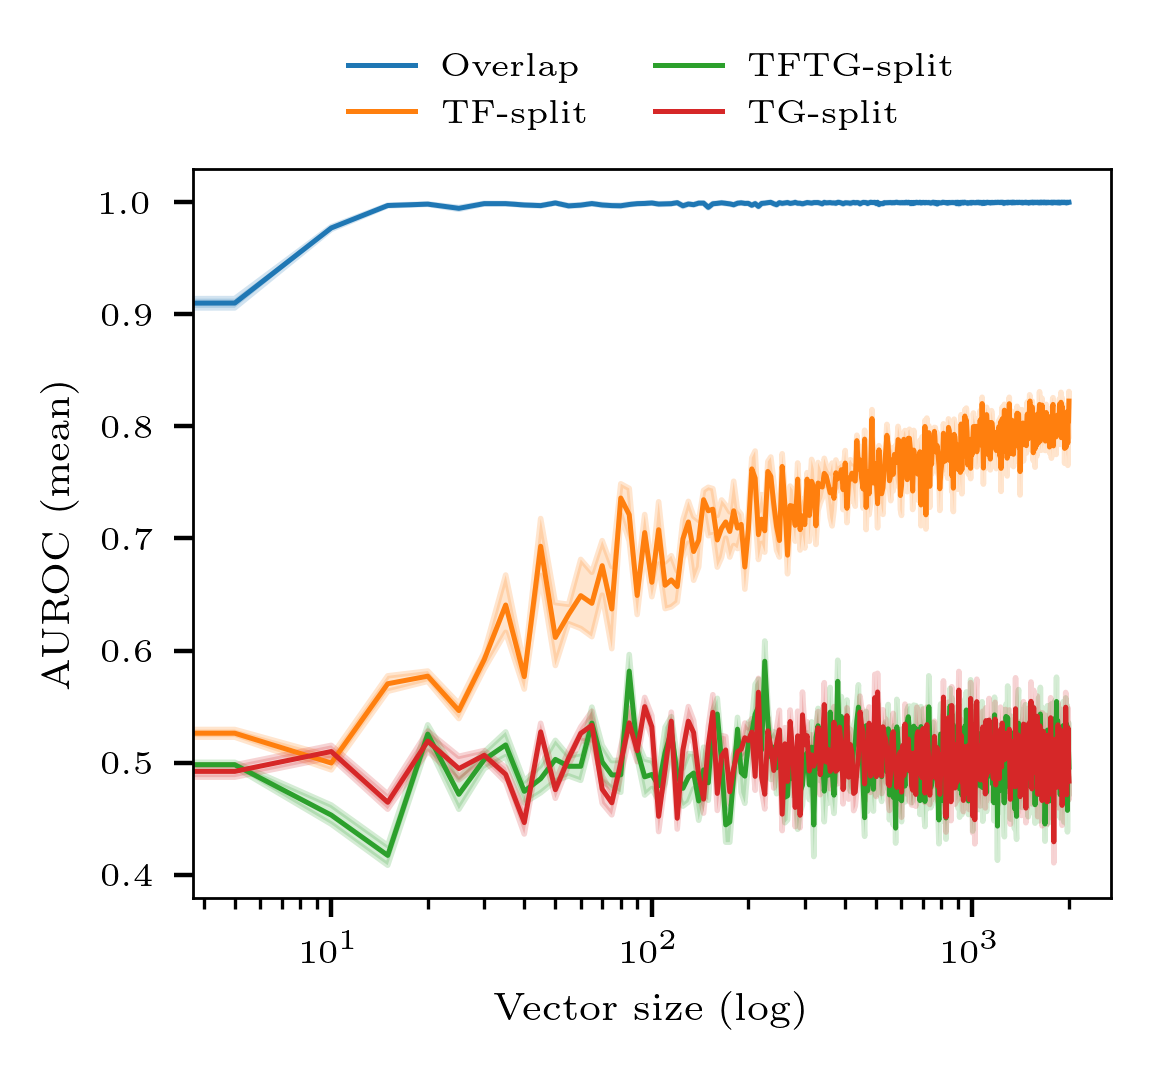

In [553]:
one_hot  = Metrics("media2/base_line/vector_length_integer")

roc, prc = auc_scores(one_hot.test)
roc_df = pd.DataFrame(roc).melt()
roc_df = pd.DataFrame(roc).melt()


roc_df.columns = ["Dataset", "VectorSize", "AUROC (mean)"]
# roc_df["VectorSize"] = 2 ** roc_df["VectorSize"]
fig, ax = plt.subplots()
g = sns.lineplot(data=roc_df, x="VectorSize", y="AUROC (mean)", hue="Dataset", ax=ax, palette="tab10")
g.set_xscale("log")
g.set_xlabel("Vector size (log)")
plt.legend(bbox_to_anchor=(0.5, 1.20), loc="upper center", ncol=2, frameon=False)
to_pgf("media2/base_line/vector_length_integer/log_length.pgf")


In [45]:
ath = pd.read_table("LABELS/Regulations_in_ATRM.tsv", index_col=0)


In [46]:
ath["Target ID"].nunique()


619

In [47]:
adj = np.empty((37336, 37336))
tfs = set()
for name, frame in ath[["TF index", "Target index"]].iterrows():
    tf, tg = frame
    tfs.update([tf])
    adj[tf, tg] = 1


In [48]:
degrees = adj.sum(axis=1)


In [49]:
test_df = one_hot.test
test_df["TargetDegree"] = test_df.Target.apply(lambda x: degrees[x])
test_df["TFDegree"] = test_df.TF.apply(lambda x: degrees[x])
test_df["Aprox"] = abs(test_df.Label - test_df.Pred)


In [50]:
test_df.VectorSize.unique


<bound method Series.unique of 0             0
1             0
2             0
3             0
4             0
           ... 
9263995    2000
9263996    2000
9263997    2000
9263998    2000
9263999    2000
Name: VectorSize, Length: 9264000, dtype: int64>

In [51]:
sample = test_df.loc[(test_df["Dataset"] == "TF-split") & (test_df["VectorSize"] == 1002)].copy()


In [52]:
mean_aprox = sample.groupby([ "TF", "Target", "TFDegree", "TargetDegree"]).Aprox.mean()


In [53]:
mean_df = pd.DataFrame(mean_aprox.index.to_list(), columns=[ "TF", "Target", "TFDegree", "TargetDegree"])
mean_df["Aprox"] = mean_aprox.values


In [54]:
mean_df


TF  Target  TFDegree  TargetDegree     Aprox
0      978   11949       2.0           0.0  0.242305
1      978   17691       2.0           0.0  0.074053
2      978   26003       2.0           0.0  0.538298
3      978   34392       2.0           0.0  0.164306
4     2406    6995       1.0           0.0  0.363996
..     ...     ...       ...           ...       ...
615  36454   23552       6.0           0.0  0.131855
616  36454   30828       6.0           4.0  0.286266
617  36454   35760       6.0           2.0  0.042991
618  36459    7756       2.0           0.0  0.031428
619  36459   25765       2.0           0.0  0.184647

[620 rows x 5 columns]

In [55]:
overlap = pd.read_table("overlap_df.tsv", index_col=0)


In [56]:
data_d = overlap.loc[(overlap["set1"] == "train") & (overlap["set2"] == "test")].copy()
data_d["total overlap"] = data_d.loc[:, "tf_u"] + data_d.loc[:, "tg_u"]


In [57]:
data_d


Dataset   set1  set2  tf_u  tf_d  tg_u  tg_d  total overlap
1        PN_1_1  train  test  1012     0   747   265           1759
4      TF_split  train  test     0  1012   272   740            272
7   TF_TG_split  train  test     0  1012     0  1012              0
10     TG_split  train  test   719   293     0  1012            719

* Overlap dataset AUROC > 0.9 at vector size == 5 
    * gene representation can take 32 (2^5) representation 
    * gene pair representation can take 32 * 31 = 992 representations
    * with vector size of 5 the model can distinguish 992 genes, 
